# OCRA Demo
This notebook shows how to train or test the model. Also included are methods to display model outputs and attention mechanimsms 

In [ ]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

# Instantiate Model for Training

In [ ]:
############################################
# set hyperparams using param file 
############################################
# param file can be 1) multimnist_params.txt or 2) multimnist_cluttered_params.txt
# params_filename = 'multimnist_cluttered_params.txt'
# params_filename = 'multisvhn_params.txt'
params_filename = 'multimnist_cluttered_params_5glimpse.txt'
args = parse_params(params_filename)

# if you have a checkpoint to restore, specify restore file (in the orginal param file or here)
# args.restore_file =  'results/multimnist_cluttered/Aug28_4014__step7_1/state_checkpoint.pt'
if args.restore_file: 
    # if you want to pick up from save-point, reload param files
    print("param file will be reloaded from your save point folder")
    path_savepoint = os.path.dirname(args.restore_file)
    params_filename = path_savepoint + '/params.txt'  
    assert os.path.isfile(params_filename), "No param flie exists"
    
    # remove the arguments that cannot be translated into literal
    removelist = ['device'] 
    args = parse_params_wremove(params_filename, removelist) 
    
    # reassign path_savepoint to restorefile
    args.restore_file = path_savepoint + '/state_checkpoint.pt'
            
# if recon_model=False, makes loss from reconstruciton 0
if not args.recon_model:
    args.lam_recon=0
    
# setup output directory where log folder should be created 
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# set device
# args.device = torch.device('cuda:{}'.format(args.cuda) if torch.cuda.is_available() and args.cuda is not None else 'cpu')
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

############################################
# instantiate model 
############################################
# set up model, optimizer, and hooks for monitoring
model = OCRA(args).to(args.device) 
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.5, 0.999))
# if args.record_attn_hooks:
#     record_forward_backward_attn_hooks(model)

# print model info
pprint.pprint(args.__dict__, sort_dicts=False)
count_parameters(model)

## start training

In [ ]:
###########################
# model training...
##########################

DO_TRAIN = True  # false if you want to skip this cell
COMMENT = 'test'

if DO_TRAIN:
    # load dataloader 
    train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')

    # set writer for tensorboard
    writer, current_log_path = set_writer(log_path = args.output_dir if args.restore_file is None else os.path.dirname(args.restore_file),
                        comment = COMMENT, 
                        restore = args.restore_file is not None) 

    args.log_dir = current_log_path

    # save used param info to writer and logging directory
    writer.add_text('Params', pprint.pformat(args.__dict__))
    
    with open(os.path.join(args.log_dir, 'params.txt'), 'w') as f:
        pprint.pprint(args.__dict__, f, sort_dicts=False)

    # start training
    print('Start training with args set above...')
    train_and_evaluate(model, train_dataloader, val_dataloader, loss_fn, optimizer, writer, args)

    writer.close()

# Test pretrained models

In [1]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

In [2]:
###########################
# model testing...
##########################

# testing parameters
DO_TEST = True # false if you want to skip this cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# give path for the model to load, or None if you want to continue with the current trained model
# load_model_path = "./pretrained/multimnist_cluttered/run1.pt"
load_model_path = None
load_model_path = './pretrained/cluttered-5glimpse/best_model_epoch687.pt'
if DO_TEST:
    if load_model_path: 
        # if path is given, load a saved model (make sure that you loaded right model args)
        print("param file will be loaded from your saved model folder")
        params_filename = os.path.dirname(load_model_path) + '/params.txt'
        assert os.path.isfile(params_filename), "No param flie exists"

        # remove the arguments that caanot be translated into literal
        removelist = ['device'] 
        args = parse_params_wremove(params_filename, removelist) 
        args.device = device 
        
        # print params
        pprint.pprint(args.__dict__, sort_dicts=False)
        
        args.use_capsnet= True
        args.num_zcaps=40
        args.use_backbone ='conv_small'
        # load model
        model = OCRA(args).to(args.device) 
        model.load_state_dict(torch.load(load_model_path,map_location=args.device))
        print('model loaded.')
        
        # get test results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

    else: # use the current trained model to get results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

param file will be loaded from your saved model folder
{'backg_objcaps': 1,
 'best_val_acc': 0,
 'cat_dup': True,
 'class_cond_mask': False,
 'clip_c': False,
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'cuda': 0,
 'data_dir': '../data/',
 'decoder_encoder_feedback': False,
 'dim_objectcaps': 16,
 'dim_zcaps': 8,
 'evaluate': True,
 'image_dims': (1, 100, 100),
 'include_xhat': False,
 'lam_recon': 175,
 'log_dir': './results/multimnist_cluttered/Jul03_1417__run9',
 'lr': 0.001,
 'lstm_size': 512,
 'mask_objectcaps': True,
 'n_epochs': 1000,
 'num_classes': 10,
 'num_targets': 2,
 'output_dir': './results/multimnist_cluttered/',
 'read_size': 18,
 'recon_model': True,
 'record_attn_hooks': False,
 'record_gradnorm': False,
 'restore_file': None,
 'routings': 3,
 'save_checkpoint': True,
 'task': 'multimnist_cluttered',
 'test': False,
 'test_batch_size': 128,
 'time_steps': 5,
 'train': True,
 'train_batch_size': 128,
 'use_capsnet': True,
 'use_backbone': 'conv_small',
 'use_read_a

##  Examining model outputs on a single test batch & plotting 

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
to_img = ToPILImage()
from PIL import Image
import os.path
import glob
import numpy as np
import math
import copy 
from matplotlib.patches import Rectangle
from IPython.display import Image as IP_Image

In [4]:
# Putting hooks to gather attention parameters
from functools import partial

read_mu_xs = []
read_mu_ys = []
def record_read_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    read_mu_xs.append(mu_x)
    read_mu_ys.append(mu_y)
    
model.read_attention_linear.register_forward_hook(partial(record_read_attn_params, bank_name='read'))


write_mu_xs = []
write_mu_ys = []
def record_write_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    write_mu_xs.append(mu_x)
    write_mu_ys.append(mu_y)

model.write_attention_linear.register_forward_hook(partial(record_write_attn_params, bank_name='write'))

# activation = []
# def get_activation(name):
#     def hook(model, input, output):
#         activation.append(output.detach())
#         print(output.detach().shape)
#     return hook

# model.bb_conv1.register_forward_hook(get_activation('bb_conv1'))

In [5]:
# test the model accuracy on a single batch 
test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
x, y = next(iter(test_dataloader))
y = y.type(torch.int64)
    
top_k = args.num_targets

# if one target and y is not in one-hot format, convert it to one-hot encoding
if args.num_targets == 1:
    if len(y.shape) < 2: 
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), args.num_classes).scatter_(1, y.view(-1, 1), 1.) 

batch_loss, batch_L_recon, batch_L_margin, batch_correct_exact, batch_correct_partial, read_x_step, \
        c_each, y_pred, objcaps_len_step, readout_logits =  evaluate(model, x, y, loss_fn, args)


read_x_step = torch.reshape(read_x_step, (args.test_batch_size,-1, *args.image_dims))
c_each = torch.reshape(c_each, (args.test_batch_size,-1, *args.image_dims))

test_loss = batch_loss / args.test_batch_size
test_L_recon = batch_L_recon / args.test_batch_size
test_L_margin = batch_L_margin / args.test_batch_size
test_acc_partial = batch_correct_partial / args.test_batch_size
test_acc_exact = batch_correct_exact / args.test_batch_size

# for visualization 
if args.task == 'mnist_ctrv':
    x = 1.0 - x

print("==> On sigle test batch: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
      % (test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

==> On sigle test batch: test_loss=0.00264, test_L_recon=0.00215, test_L_margin=0.00049, test_acc_partial=0.9531, test_acc_exact=0.9062


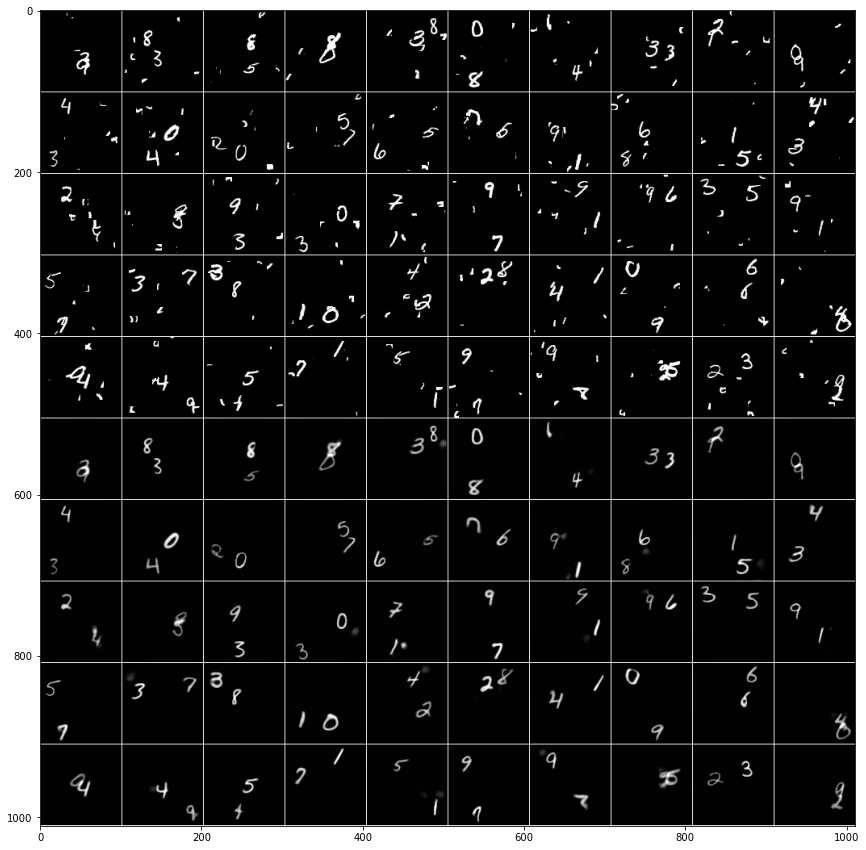

torch.Size([640, 1, 100, 100])


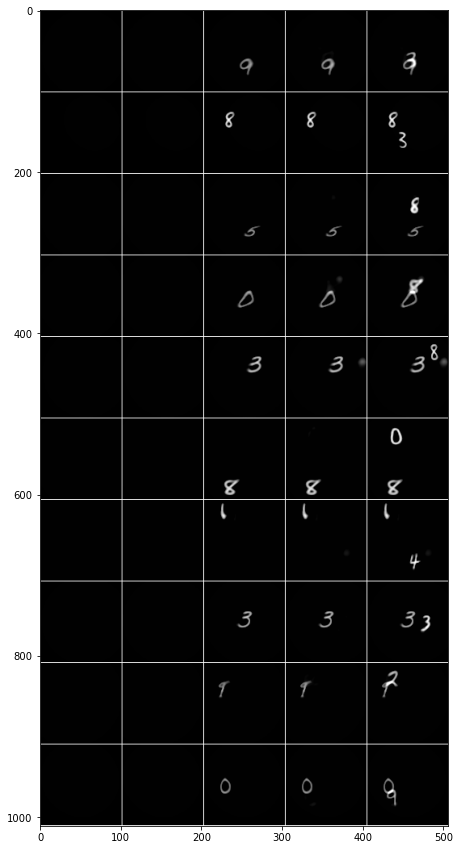

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


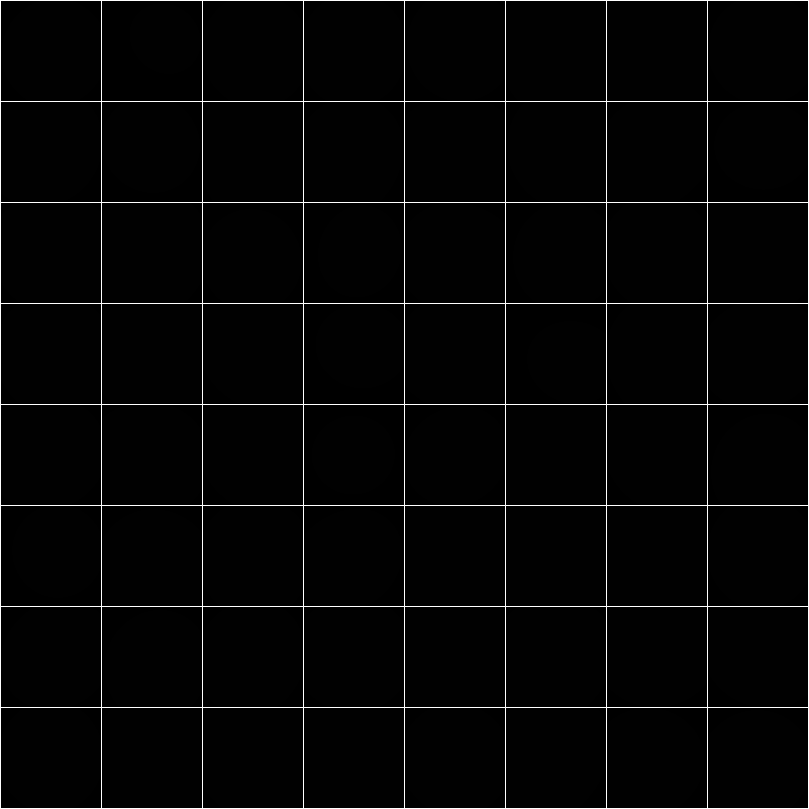

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# plot and save image outputs
img_g = torch.cat((x[:50].to(args.device),torch.sum(c_each,dim=1)[:50]))
img_g = make_grid(img_g, nrow=10, padding=1, normalize=False, pad_value=1)
save_name = 'image_grid_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size, args.time_steps, args.num_targets)
save_image(img_g, os.path.join(args.output_dir, save_name))
img_g = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(img_g) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# reconstructoin steps
c_cumu_step = []
for i in range(args.time_steps):
    c_cumu_step.append(torch.squeeze(torch.cumsum(c_each,dim=1).narrow(1,i,1)))
        
        
num_imgs = 10
images = torch.stack(c_cumu_step, dim=1).view(-1, *args.image_dims)  # reshape to (10*time_steps, 1, 28, 28)
print(images.shape)
images = make_grid(images[0:num_imgs*len(c_cumu_step)], nrow=len(c_cumu_step), padding=1, normalize=False, pad_value=1)
save_name = 'generated_sequences_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size,args.time_steps,args.num_targets)


save_image(images, os.path.join(args.output_dir, save_name))
images = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(images) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# make gif
num_imgs = 64
c_cumu_step_gif = copy.deepcopy(c_cumu_step)
for i in range(len(c_cumu_step)):
    # convert sequence of image tensors to 8x8 grid
    image = make_grid(c_cumu_step[i][:num_imgs].view(-1, *args.image_dims).clip(max=1).cpu(), \
                      nrow=int(math.sqrt(num_imgs)), padding=1, normalize=False, pad_value=1)
    # make into gif
    c_cumu_step_gif[i] = image.data.numpy().transpose(1,2,0)

import imageio
file_add = (os.path.join(args.output_dir, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
imageio.mimsave(file_add, c_cumu_step_gif)

IP_Image(open(file_add,'rb').read(), width = 600, height = 600)

## Plotting attention windows for all timesteps 


****************************************************************************************************
trial 0

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
model prediction
tensor([0.1207, 0.1188, 0.1309, 0.9091, 0.0693, 0.1140, 0.1176, 0.1053, 0.0688,
        0.8993])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
partial score, 1.0, exact score, True


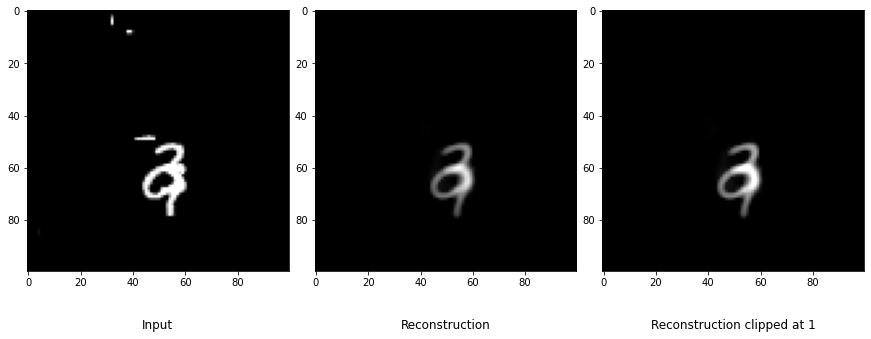

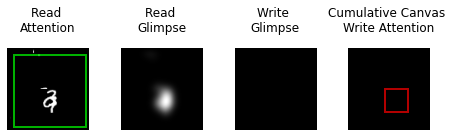

tensor([3.6791e-03, 4.3176e-03, 1.2929e-02, 1.7683e-02, 4.5261e-03, 1.0553e-01,
        1.7762e-02, 9.9282e-03, 3.5523e-02, 1.0175e-01, 3.8164e-06])
tensor([ 5,  9,  8,  6,  3,  2,  7,  4,  1,  0, 10])


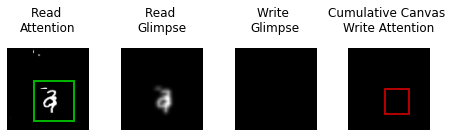

tensor([7.9705e-02, 9.4921e-02, 1.6017e-02, 4.9936e-03, 3.8877e-02, 2.3396e-03,
        7.7361e-02, 9.1919e-03, 4.6058e-03, 3.0651e-03, 1.3912e-05])
tensor([ 1,  0,  6,  4,  2,  7,  3,  8,  9,  5, 10])


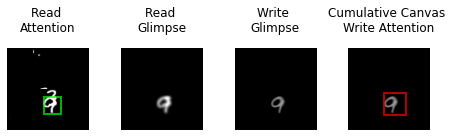

tensor([3.1502e-03, 7.4761e-03, 1.6529e-02, 3.6799e-03, 5.0673e-03, 1.8184e-03,
        3.8947e-03, 5.7277e-03, 6.8479e-03, 7.7928e-01, 1.8279e-04])
tensor([ 9,  2,  1,  8,  7,  4,  6,  3,  0,  5, 10])


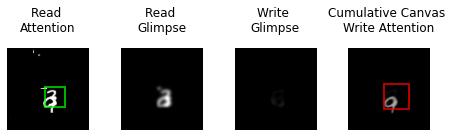

tensor([3.1859e-02, 6.7740e-03, 2.9407e-02, 1.8114e-01, 1.9273e-02, 1.3357e-03,
        1.3999e-02, 7.3106e-02, 1.7191e-02, 1.3126e-02, 1.3197e-05])
tensor([ 3,  7,  0,  2,  4,  8,  6,  9,  1,  5, 10])


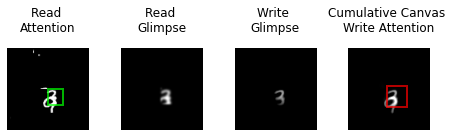

tensor([2.3545e-03, 5.2715e-03, 5.5982e-02, 7.0165e-01, 1.5860e-03, 2.9631e-03,
        4.6224e-03, 7.3874e-03, 4.6475e-03, 2.1161e-03, 5.4906e-05])
tensor([ 3,  2,  7,  1,  8,  6,  5,  0,  9,  4, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.2075e-01, 1.1876e-01, 1.3086e-01, 9.0914e-01, 6.9329e-02, 1.1399e-01,
        1.1764e-01, 1.0534e-01, 6.8815e-02, 8.9934e-01, 2.6862e-04],
       device='cuda:0')
tensor([ 3,  9,  2,  0,  1,  6,  5,  7,  4,  8, 10], device='cuda:0')

****************************************************************************************************
trial 1

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([3, 8])
model prediction
tensor([0.0819, 0.0742, 0.0811, 0.9484, 0.0705, 0.1144, 0.0706, 0.0538, 1.1734,
        0.0692])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([3, 8])
partial score, 1.0, exact score, True


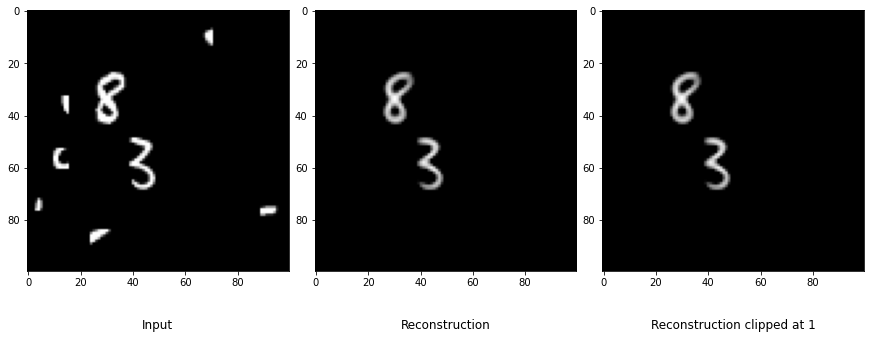

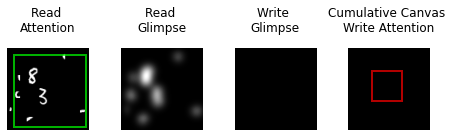

tensor([1.2389e-03, 5.3075e-03, 8.8810e-03, 2.0050e-02, 4.9964e-04, 1.0552e-01,
        2.3344e-03, 1.0903e-02, 1.5130e-02, 5.0162e-02, 2.4967e-06])
tensor([ 5,  9,  3,  8,  7,  2,  1,  6,  0,  4, 10])


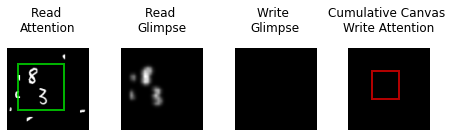

tensor([7.5350e-02, 6.5089e-02, 5.8458e-02, 2.0861e-02, 6.4340e-02, 3.7836e-03,
        6.1968e-02, 2.7974e-02, 1.6266e-02, 1.5753e-02, 2.9595e-05])
tensor([ 0,  1,  4,  6,  2,  7,  3,  8,  9,  5, 10])


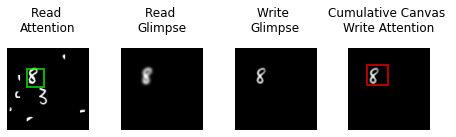

tensor([2.4312e-03, 1.2509e-03, 4.7029e-03, 4.5041e-03, 1.4476e-03, 1.5456e-03,
        2.0215e-03, 4.0216e-03, 8.6406e-01, 1.3788e-03, 1.6086e-04])
tensor([ 8,  2,  3,  7,  0,  6,  5,  4,  9,  1, 10])


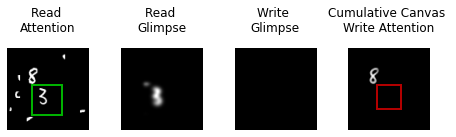

tensor([1.0810e-03, 1.0329e-03, 5.5272e-03, 2.1076e-02, 2.2735e-03, 1.9897e-03,
        2.0090e-03, 7.2943e-03, 2.7368e-01, 8.2638e-04, 3.1916e-05])
tensor([ 8,  3,  7,  2,  4,  6,  5,  0,  1,  9, 10])


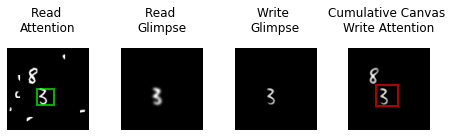

tensor([1.8028e-03, 1.5113e-03, 3.4854e-03, 8.8192e-01, 1.9824e-03, 1.5554e-03,
        2.3133e-03, 3.6014e-03, 4.2307e-03, 1.0637e-03, 1.7198e-04])
tensor([ 3,  8,  7,  2,  6,  4,  0,  5,  1,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([8.1904e-02, 7.4192e-02, 8.1055e-02, 9.4841e-01, 7.0543e-02, 1.1439e-01,
        7.0646e-02, 5.3794e-02, 1.1734e+00, 6.9184e-02, 3.9685e-04],
       device='cuda:0')
tensor([ 8,  3,  5,  0,  2,  1,  6,  4,  9,  7, 10], device='cuda:0')

****************************************************************************************************
trial 2

ground truth
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0])
tensor([5, 8])
model prediction
tensor([0.1044, 0.0682, 0.0643, 0.0329, 0.0744, 1.1634, 0.1193, 0.0533, 0.9414,
        0.0426])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0])
tensor([5, 8])
partial score, 1.0, exact score, True


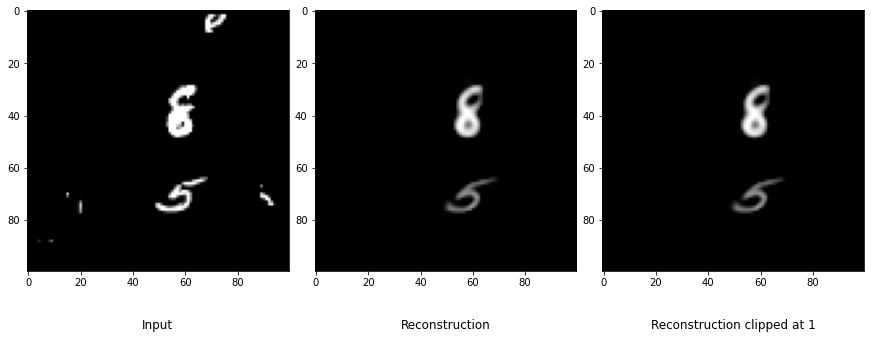

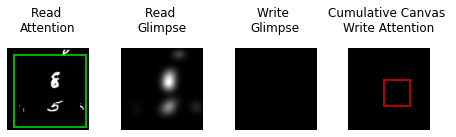

tensor([1.1946e-03, 8.7882e-03, 1.0941e-02, 1.3849e-02, 8.0172e-03, 6.9904e-02,
        8.0890e-03, 9.3472e-03, 2.7164e-02, 3.1545e-02, 6.3024e-06])
tensor([ 5,  9,  8,  3,  2,  7,  1,  6,  4,  0, 10])


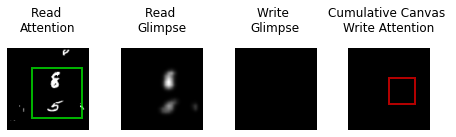

tensor([9.5591e-02, 5.3008e-02, 3.7228e-02, 8.8428e-03, 6.1271e-02, 1.1056e-03,
        1.0020e-01, 1.6917e-02, 1.2147e-02, 8.3285e-03, 3.8827e-05])
tensor([ 6,  0,  4,  1,  2,  7,  8,  3,  9,  5, 10])


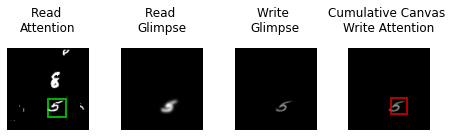

tensor([3.9210e-03, 2.4627e-03, 4.1303e-03, 4.8378e-03, 3.6359e-03, 7.6995e-01,
        2.1047e-03, 5.3284e-03, 2.2964e-02, 1.0160e-03, 9.0479e-05])
tensor([ 5,  8,  7,  3,  2,  0,  4,  1,  6,  9, 10])


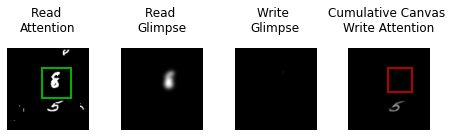

tensor([1.2709e-03, 1.0846e-03, 5.8167e-03, 2.4348e-03, 6.5940e-04, 3.2148e-01,
        1.2996e-03, 9.2839e-03, 3.0930e-02, 8.6882e-04, 1.9320e-05])
tensor([ 5,  8,  7,  2,  3,  6,  0,  1,  9,  4, 10])


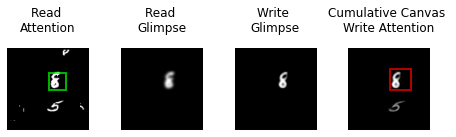

tensor([2.4706e-03, 2.8547e-03, 6.2115e-03, 2.9123e-03, 8.5685e-04, 9.5813e-04,
        7.5893e-03, 1.2456e-02, 8.4820e-01, 8.3248e-04, 1.3871e-04])
tensor([ 8,  7,  6,  2,  3,  1,  0,  5,  4,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0445e-01, 6.8199e-02, 6.4328e-02, 3.2876e-02, 7.4440e-02, 1.1634e+00,
        1.1928e-01, 5.3333e-02, 9.4141e-01, 4.2591e-02, 2.9364e-04],
       device='cuda:0')
tensor([ 5,  8,  6,  0,  4,  1,  2,  7,  9,  3, 10], device='cuda:0')

****************************************************************************************************
trial 3

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 8])
model prediction
tensor([1.1316, 0.2537, 0.0626, 0.0554, 0.0736, 0.0880, 0.0530, 0.0881, 0.7744,
        0.0661])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 8])
partial score, 1.0, exact score, True


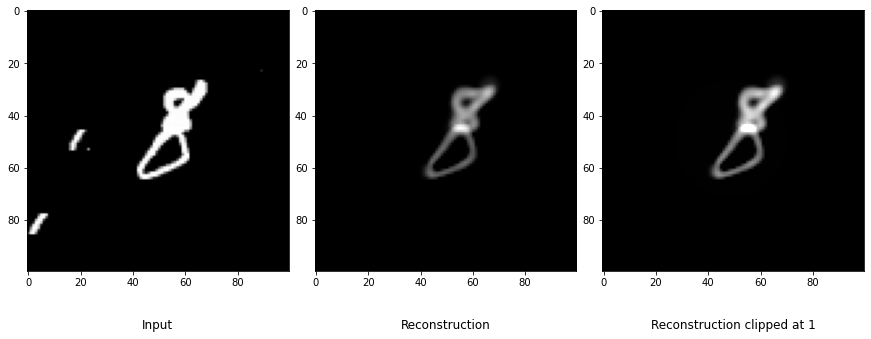

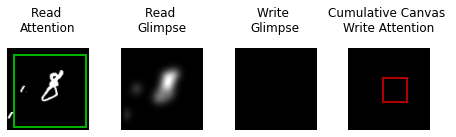

tensor([1.4499e-02, 6.8453e-02, 2.8975e-02, 2.5413e-02, 1.2969e-02, 8.1355e-02,
        1.3261e-02, 2.0154e-02, 1.9741e-02, 4.9667e-02, 7.8454e-06])
tensor([ 5,  1,  9,  2,  3,  7,  8,  0,  6,  4, 10])


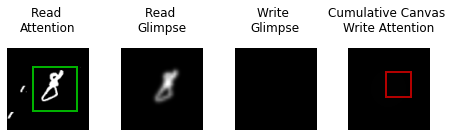

tensor([9.1104e-02, 1.4470e-01, 4.7053e-03, 4.2286e-03, 3.8083e-02, 1.8057e-03,
        1.6572e-02, 1.1407e-02, 6.6955e-03, 2.1737e-03, 1.7574e-05])
tensor([ 1,  0,  4,  6,  7,  8,  2,  3,  9,  5, 10])


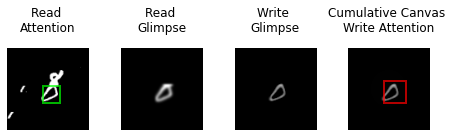

tensor([8.0349e-01, 3.7673e-03, 1.1530e-02, 7.4124e-03, 8.3533e-03, 1.3565e-03,
        9.6010e-03, 1.0307e-02, 6.9446e-03, 2.9715e-03, 1.3014e-04])
tensor([ 0,  2,  7,  6,  4,  3,  8,  1,  9,  5, 10])


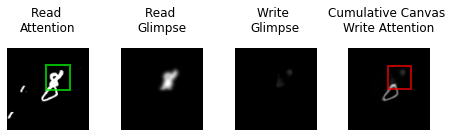

tensor([2.1388e-01, 2.7017e-02, 7.0662e-03, 1.0445e-02, 9.7529e-03, 1.8534e-03,
        5.5067e-03, 4.0694e-02, 1.5931e-02, 9.4493e-03, 1.6999e-05])
tensor([ 0,  7,  1,  8,  3,  4,  9,  2,  6,  5, 10])


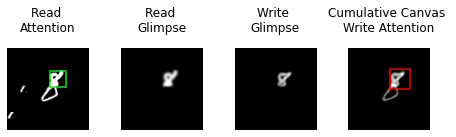

tensor([8.6414e-03, 9.7391e-03, 1.0365e-02, 7.8826e-03, 4.4753e-03, 1.6310e-03,
        8.0428e-03, 5.5081e-03, 7.2511e-01, 1.8738e-03, 5.1713e-05])
tensor([ 8,  2,  1,  0,  6,  3,  7,  4,  9,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.1316e+00, 2.5367e-01, 6.2642e-02, 5.5382e-02, 7.3634e-02, 8.8001e-02,
        5.2983e-02, 8.8070e-02, 7.7442e-01, 6.6135e-02, 2.2427e-04],
       device='cuda:0')
tensor([ 0,  8,  1,  7,  5,  4,  9,  2,  3,  6, 10], device='cuda:0')

****************************************************************************************************
trial 4

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([3, 8])
model prediction
tensor([0.1674, 0.0534, 0.0533, 1.2769, 0.0806, 0.1708, 0.0566, 0.0455, 0.9642,
        0.1183])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([3, 8])
partial score, 1.0, exact score, True


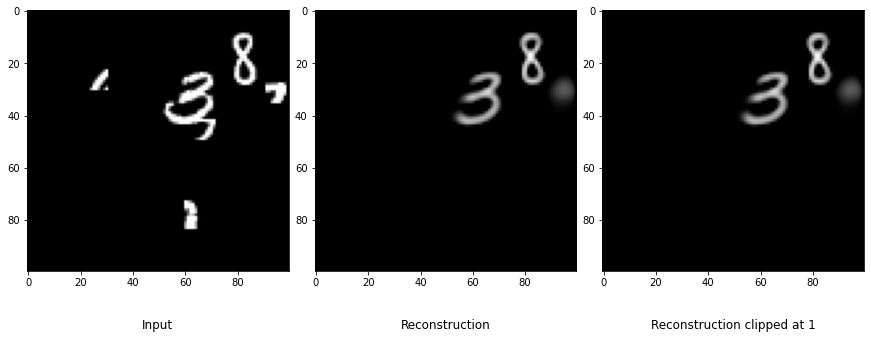

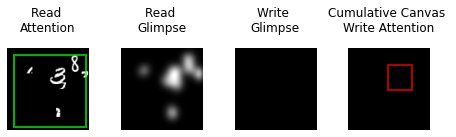

tensor([3.3962e-03, 7.1249e-03, 1.0596e-02, 2.7695e-02, 1.1925e-03, 1.5328e-01,
        2.1863e-03, 1.2790e-02, 2.1495e-02, 1.0992e-01, 5.1252e-06])
tensor([ 5,  9,  3,  8,  7,  2,  1,  0,  6,  4, 10])


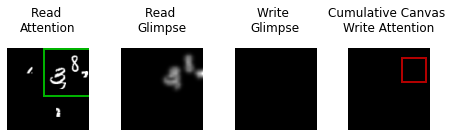

tensor([1.5029e-01, 4.0621e-02, 1.5938e-02, 1.7582e-02, 7.2235e-02, 3.3242e-03,
        4.0301e-02, 1.0690e-02, 3.4357e-03, 8.0831e-04, 1.8385e-05])
tensor([ 0,  4,  1,  6,  3,  2,  7,  8,  5,  9, 10])


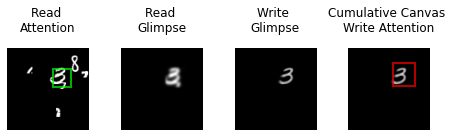

tensor([9.4964e-03, 2.4266e-03, 9.8238e-03, 8.4637e-01, 4.2234e-03, 7.7415e-03,
        5.2992e-03, 6.9349e-03, 2.4657e-02, 4.4112e-03, 2.0386e-04])
tensor([ 3,  8,  2,  0,  5,  7,  6,  9,  4,  1, 10])


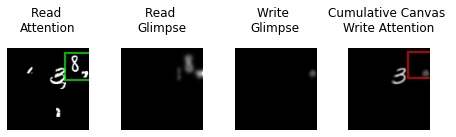

tensor([2.2677e-03, 1.5857e-03, 1.0012e-02, 3.6417e-01, 1.1040e-03, 2.5715e-03,
        3.0281e-03, 1.0253e-02, 2.6785e-02, 1.9952e-03, 5.5994e-05])
tensor([ 3,  8,  7,  2,  6,  5,  0,  9,  1,  4, 10])


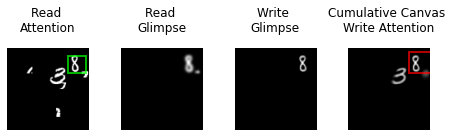

tensor([1.9315e-03, 1.6655e-03, 6.9010e-03, 2.1062e-02, 1.8473e-03, 3.9042e-03,
        5.7950e-03, 4.8554e-03, 8.8781e-01, 1.1546e-03, 1.6290e-04])
tensor([ 8,  3,  2,  6,  7,  5,  0,  4,  1,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.6739e-01, 5.3424e-02, 5.3271e-02, 1.2769e+00, 8.0603e-02, 1.7082e-01,
        5.6610e-02, 4.5523e-02, 9.6419e-01, 1.1829e-01, 4.4627e-04],
       device='cuda:0')
tensor([ 3,  8,  5,  0,  9,  4,  6,  1,  2,  7, 10], device='cuda:0')

****************************************************************************************************
trial 5

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 8])
model prediction
tensor([0.9908, 0.0750, 0.0557, 0.0541, 0.0966, 0.1292, 0.1530, 0.0681, 1.0949,
        0.0685])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 8])
partial score, 1.0, exact score, True


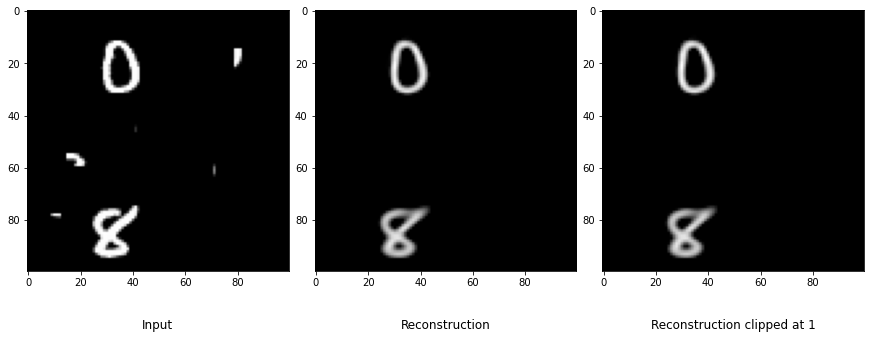

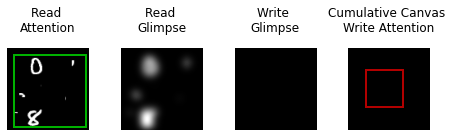

tensor([1.1610e-02, 8.9842e-03, 7.8138e-03, 2.8436e-02, 8.1530e-03, 1.1929e-01,
        1.3637e-02, 1.1295e-02, 7.9876e-03, 3.7142e-02, 9.3949e-06])
tensor([ 5,  9,  3,  6,  0,  7,  1,  4,  8,  2, 10])


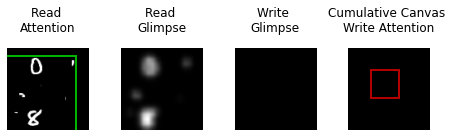

tensor([6.8866e-02, 6.1581e-02, 3.5791e-02, 5.1657e-03, 7.8038e-02, 3.9466e-03,
        1.3208e-01, 4.2144e-02, 1.6971e-02, 2.3111e-02, 3.9581e-05])
tensor([ 6,  4,  0,  1,  7,  2,  9,  8,  3,  5, 10])


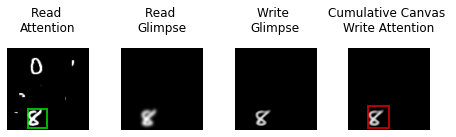

tensor([4.4186e-03, 2.2715e-03, 3.7988e-03, 8.1038e-03, 4.4979e-03, 2.1877e-03,
        2.3117e-03, 6.1528e-03, 8.3480e-01, 2.7057e-03, 6.8388e-05])
tensor([ 8,  3,  7,  4,  0,  2,  9,  6,  1,  5, 10])


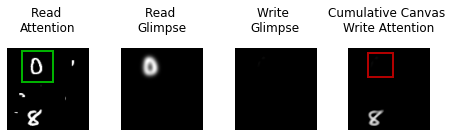

tensor([4.8450e-02, 9.6148e-04, 3.3081e-03, 7.1403e-03, 1.2047e-03, 2.3422e-03,
        1.5610e-03, 3.6401e-03, 2.2814e-01, 2.6698e-03, 2.3201e-05])
tensor([ 8,  0,  3,  7,  2,  9,  5,  6,  4,  1, 10])


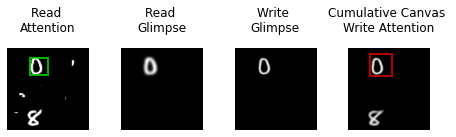

tensor([8.5743e-01, 1.2454e-03, 4.9539e-03, 5.2509e-03, 4.6913e-03, 1.4696e-03,
        3.4536e-03, 4.8913e-03, 6.9558e-03, 2.9024e-03, 1.1496e-04])
tensor([ 0,  8,  3,  2,  7,  4,  6,  9,  5,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([9.9078e-01, 7.5043e-02, 5.5665e-02, 5.4096e-02, 9.6585e-02, 1.2923e-01,
        1.5304e-01, 6.8123e-02, 1.0949e+00, 6.8531e-02, 2.5553e-04],
       device='cuda:0')
tensor([ 8,  0,  6,  5,  4,  1,  9,  7,  2,  3, 10], device='cuda:0')

****************************************************************************************************
trial 6

ground truth
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 4])
model prediction
tensor([0.0580, 1.0026, 0.0812, 0.0560, 1.2059, 0.0921, 0.0530, 0.0513, 0.0748,
        0.1246])
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 4])
partial score, 1.0, exact score, True


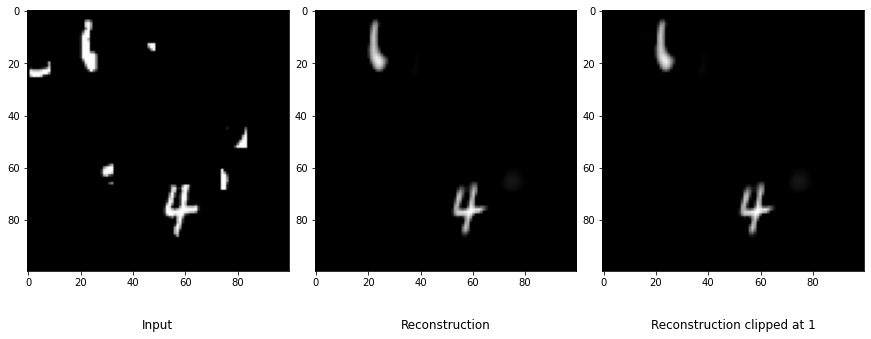

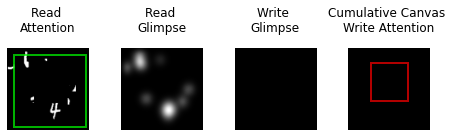

tensor([1.8211e-02, 1.4035e-02, 2.0298e-03, 1.7570e-02, 4.9699e-03, 5.0618e-02,
        8.2319e-03, 2.4837e-03, 1.3775e-02, 1.0708e-01, 7.1480e-06])
tensor([ 9,  5,  0,  3,  1,  8,  6,  4,  7,  2, 10])


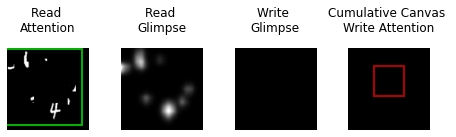

tensor([3.1103e-02, 1.1410e-01, 4.4996e-02, 1.0119e-02, 1.2204e-01, 2.1926e-02,
        2.9442e-02, 1.3462e-02, 1.7821e-02, 1.0760e-02, 3.4462e-05])
tensor([ 4,  1,  2,  0,  6,  5,  8,  7,  9,  3, 10])


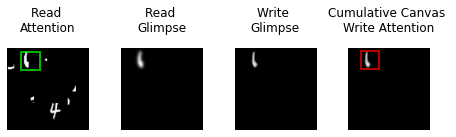

tensor([1.7856e-03, 7.6539e-01, 3.6534e-03, 3.9684e-03, 1.9139e-03, 1.6867e-03,
        9.2241e-03, 7.5814e-03, 7.1323e-03, 3.9670e-03, 3.8417e-05])
tensor([ 1,  6,  7,  8,  3,  9,  2,  4,  0,  5, 10])


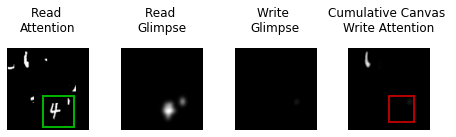

tensor([2.8644e-03, 1.0658e-01, 1.1732e-02, 1.3377e-02, 1.9668e-01, 1.6238e-02,
        4.2318e-03, 7.4131e-03, 1.9586e-02, 1.7283e-03, 1.3680e-05])
tensor([ 4,  1,  8,  5,  3,  2,  7,  6,  0,  9, 10])


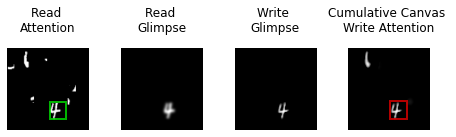

tensor([4.0561e-03, 2.5525e-03, 1.8831e-02, 1.0997e-02, 8.8025e-01, 1.6808e-03,
        1.8533e-03, 2.0394e-02, 1.6442e-02, 1.0777e-03, 1.4020e-04])
tensor([ 4,  7,  2,  8,  3,  0,  1,  6,  5,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.8020e-02, 1.0026e+00, 8.1242e-02, 5.6030e-02, 1.2059e+00, 9.2150e-02,
        5.2983e-02, 5.1334e-02, 7.4756e-02, 1.2461e-01, 2.3391e-04],
       device='cuda:0')
tensor([ 4,  1,  9,  5,  2,  8,  0,  3,  6,  7, 10], device='cuda:0')

****************************************************************************************************
trial 7

ground truth
tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 0])
tensor([3, 3])
model prediction
tensor([0.1078, 0.0904, 0.1086, 2.0343, 0.0988, 0.0854, 0.0978, 0.0885, 0.0451,
        0.0748])
tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 0])
tensor([3, 3])
partial score, 1.0, exact score, True


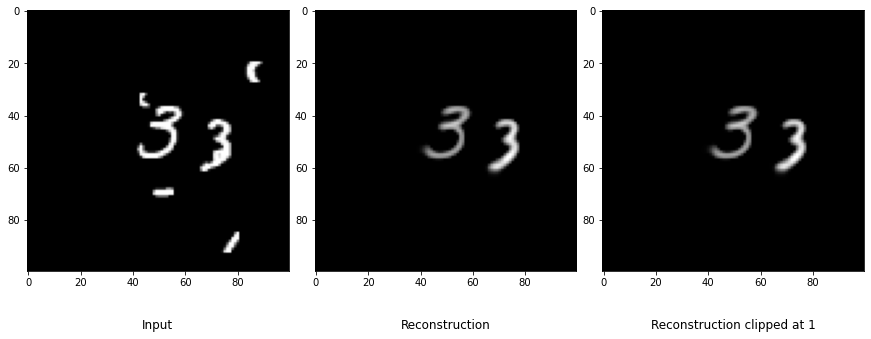

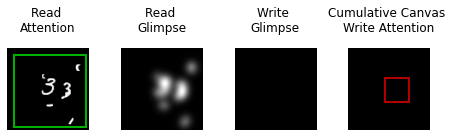

tensor([3.0489e-03, 2.5359e-03, 9.9476e-03, 2.9463e-02, 2.3495e-03, 7.6799e-02,
        5.2443e-03, 6.7825e-03, 5.5998e-03, 6.2657e-02, 4.1534e-06])
tensor([ 5,  9,  3,  2,  7,  8,  6,  0,  1,  4, 10])


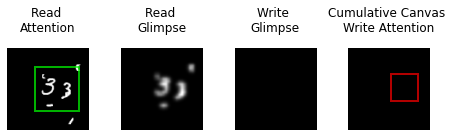

tensor([9.8067e-02, 8.3812e-02, 7.1605e-02, 1.5357e-02, 9.1085e-02, 4.0524e-03,
        8.4556e-02, 6.3198e-02, 6.8483e-03, 1.9812e-03, 2.6439e-05])
tensor([ 0,  4,  6,  1,  2,  7,  3,  8,  5,  9, 10])


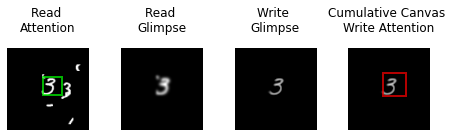

tensor([2.3534e-03, 1.8840e-03, 3.8445e-03, 8.6106e-01, 1.3220e-03, 4.6038e-04,
        1.0675e-03, 2.0746e-03, 2.0141e-03, 1.8187e-03, 1.3378e-04])
tensor([ 3,  2,  0,  7,  8,  1,  9,  4,  6,  5, 10])


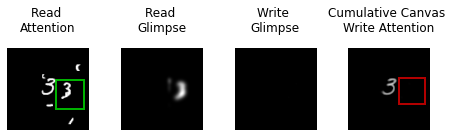

tensor([1.9989e-03, 5.9019e-04, 1.7548e-02, 2.8136e-01, 1.3577e-03, 1.5296e-03,
        1.3440e-03, 8.2418e-03, 1.2831e-02, 1.9019e-03, 3.0783e-05])
tensor([ 3,  2,  8,  7,  0,  9,  5,  4,  6,  1, 10])


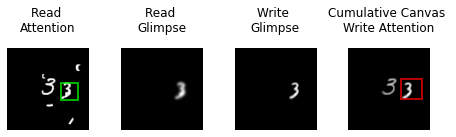

tensor([2.3619e-03, 1.5347e-03, 5.6831e-03, 8.4707e-01, 2.6837e-03, 2.5878e-03,
        5.5855e-03, 8.1871e-03, 1.7816e-02, 6.4189e-03, 1.3295e-04])
tensor([ 3,  8,  7,  9,  2,  6,  4,  5,  0,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0783e-01, 9.0357e-02, 1.0863e-01, 2.0343e+00, 9.8798e-02, 8.5429e-02,
        9.7797e-02, 8.8484e-02, 4.5109e-02, 7.4778e-02, 3.2811e-04],
       device='cuda:0')
tensor([ 3,  2,  0,  4,  6,  1,  7,  5,  9,  8, 10], device='cuda:0')

****************************************************************************************************
trial 8

ground truth
tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 2])
model prediction
tensor([0.0710, 0.2653, 1.0784, 0.0537, 0.0829, 0.1981, 0.0470, 0.1147, 0.0859,
        0.8164])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
tensor([2, 9])
partial score, 0.5, exact score, False


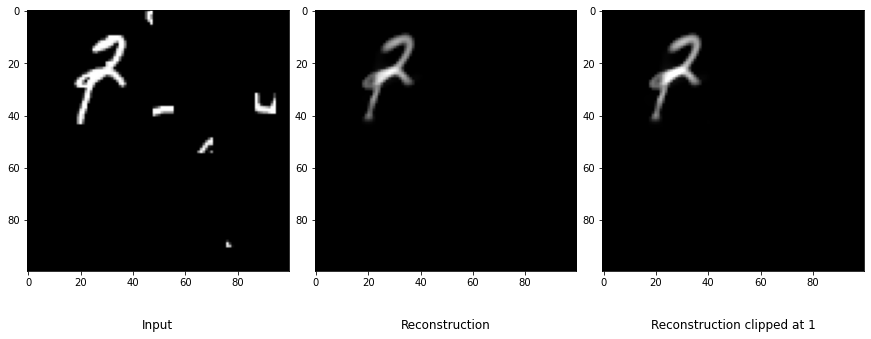

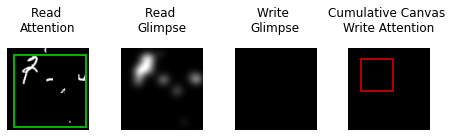

tensor([4.5238e-03, 1.8108e-02, 1.7133e-02, 1.9099e-02, 3.4730e-03, 1.8578e-01,
        2.1317e-03, 1.4396e-02, 2.1458e-02, 8.6102e-02, 4.6474e-06])
tensor([ 5,  9,  8,  3,  1,  2,  7,  0,  4,  6, 10])


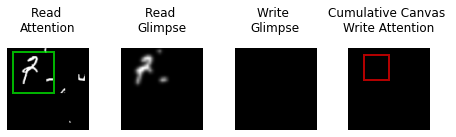

tensor([4.8360e-02, 1.3445e-01, 4.3675e-03, 3.8156e-03, 6.9949e-02, 7.3305e-03,
        2.9885e-02, 1.1087e-02, 4.0149e-03, 3.8476e-03, 4.1511e-06])
tensor([ 1,  4,  0,  6,  7,  5,  2,  8,  9,  3, 10])


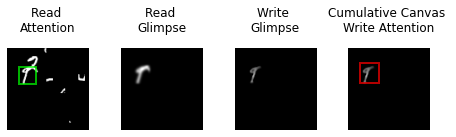

tensor([2.1530e-03, 1.0305e-01, 9.6499e-03, 5.1780e-03, 2.4737e-03, 2.4499e-03,
        6.1097e-03, 5.6688e-02, 5.5758e-03, 7.1890e-01, 5.9643e-05])
tensor([ 9,  1,  7,  2,  6,  8,  3,  4,  5,  0, 10])


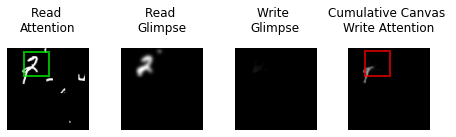

tensor([1.3507e-02, 6.8525e-03, 2.0805e-01, 2.0628e-02, 3.5380e-03, 1.7157e-03,
        5.3948e-03, 2.8288e-02, 3.1578e-02, 4.7461e-03, 2.0686e-05])
tensor([ 2,  8,  7,  3,  0,  1,  6,  9,  4,  5, 10])


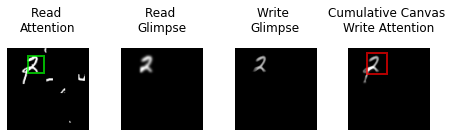

tensor([2.4673e-03, 2.8408e-03, 8.3922e-01, 4.9720e-03, 3.4745e-03, 8.1242e-04,
        3.4619e-03, 4.2048e-03, 2.3250e-02, 2.7657e-03, 1.3606e-04])
tensor([ 2,  8,  3,  7,  4,  6,  1,  9,  0,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.1011e-02, 2.6530e-01, 1.0784e+00, 5.3692e-02, 8.2909e-02, 1.9809e-01,
        4.6983e-02, 1.1466e-01, 8.5876e-02, 8.1637e-01, 2.2518e-04],
       device='cuda:0')
tensor([ 2,  9,  1,  5,  7,  8,  4,  0,  3,  6, 10], device='cuda:0')

****************************************************************************************************
trial 9

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 9])
model prediction
tensor([1.0785, 0.0723, 0.0777, 0.0495, 0.0897, 0.1604, 0.0910, 0.0508, 0.0599,
        0.9232])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 9])
partial score, 1.0, exact score, True


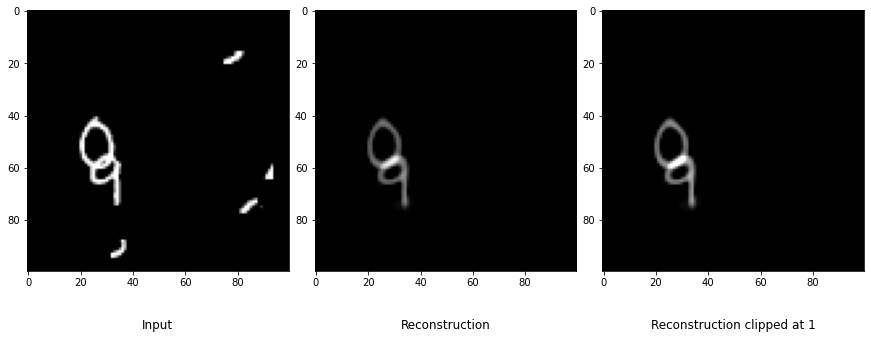

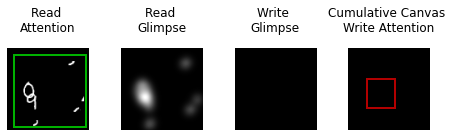

tensor([4.3492e-03, 4.6866e-03, 1.5268e-02, 2.6531e-02, 1.6341e-03, 1.4408e-01,
        6.0381e-03, 7.4058e-03, 3.7572e-02, 6.9810e-02, 4.3152e-06])
tensor([ 5,  9,  8,  3,  2,  7,  6,  1,  0,  4, 10])


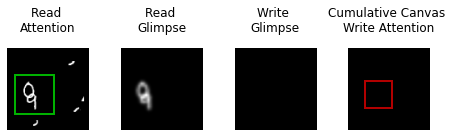

tensor([8.5571e-02, 6.1208e-02, 4.8941e-02, 7.9131e-03, 8.1113e-02, 2.2368e-03,
        7.4222e-02, 2.9319e-02, 7.2321e-03, 1.0645e-02, 4.2663e-05])
tensor([ 0,  4,  6,  1,  2,  7,  9,  3,  8,  5, 10])


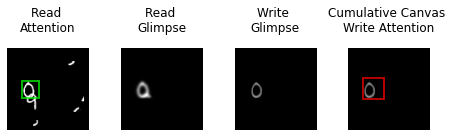

tensor([7.6800e-01, 1.7948e-03, 4.1482e-03, 4.2679e-03, 3.1658e-03, 4.2019e-03,
        4.9595e-03, 5.9764e-03, 5.0582e-03, 1.4349e-02, 9.7329e-05])
tensor([ 0,  9,  7,  8,  6,  3,  5,  2,  4,  1, 10])


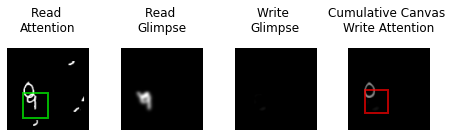

tensor([2.1505e-01, 3.6800e-03, 4.3859e-03, 6.2143e-03, 2.0059e-03, 7.2837e-03,
        3.3393e-03, 2.6868e-03, 4.4575e-03, 1.3606e-02, 2.1350e-05])
tensor([ 0,  9,  5,  3,  8,  2,  1,  6,  7,  4, 10])


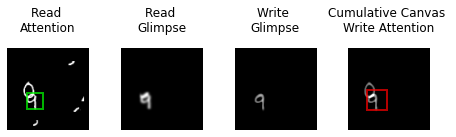

tensor([5.5102e-03, 9.4200e-04, 4.9848e-03, 4.5310e-03, 1.7408e-03, 2.5938e-03,
        2.4851e-03, 5.4160e-03, 5.6148e-03, 8.1481e-01, 1.7539e-04])
tensor([ 9,  8,  0,  7,  2,  3,  5,  6,  4,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0785e+00, 7.2312e-02, 7.7728e-02, 4.9458e-02, 8.9659e-02, 1.6040e-01,
        9.1044e-02, 5.0803e-02, 5.9935e-02, 9.2322e-01, 3.4104e-04],
       device='cuda:0')
tensor([ 0,  9,  5,  6,  4,  2,  1,  8,  7,  3, 10], device='cuda:0')

****************************************************************************************************
trial 10

ground truth
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
tensor([3, 4])
model prediction
tensor([0.0333, 0.1855, 0.0444, 1.1831, 0.9631, 0.1399, 0.0838, 0.0300, 0.0301,
        0.1109])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
tensor([3, 4])
partial score, 1.0, exact score, True


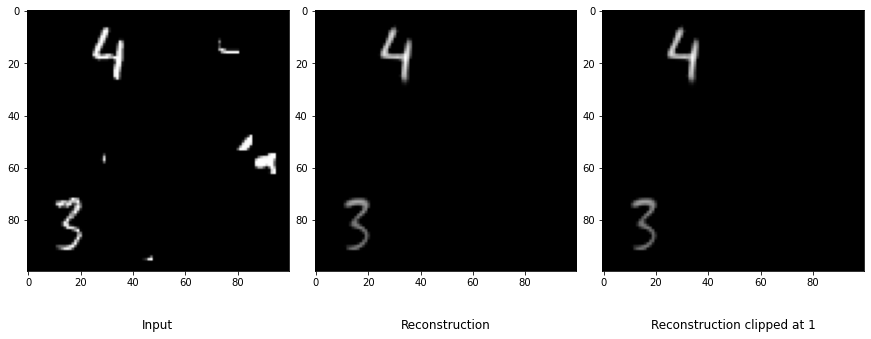

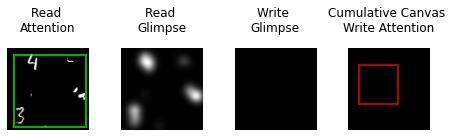

tensor([1.3309e-02, 1.0664e-02, 4.5859e-03, 2.0107e-02, 6.2148e-03, 1.3307e-01,
        3.9949e-03, 9.5216e-03, 1.2741e-02, 8.0996e-02, 5.9457e-06])
tensor([ 5,  9,  3,  0,  8,  1,  7,  4,  2,  6, 10])


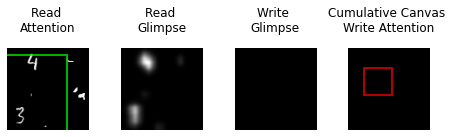

tensor([1.4549e-02, 1.7315e-01, 2.4926e-02, 3.8520e-03, 1.0324e-01, 2.9333e-03,
        7.3603e-02, 6.6267e-03, 4.1455e-03, 2.5326e-02, 2.1197e-05])
tensor([ 1,  4,  6,  9,  2,  0,  7,  8,  3,  5, 10])


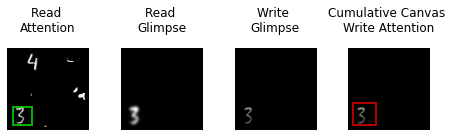

tensor([9.4042e-04, 6.4381e-04, 3.5490e-03, 8.4859e-01, 7.8194e-04, 4.7281e-04,
        1.4848e-03, 5.5027e-03, 6.1588e-03, 5.7681e-04, 1.1192e-04])
tensor([ 3,  8,  7,  2,  6,  0,  4,  1,  9,  5, 10])


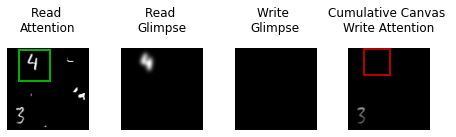

tensor([2.9185e-03, 5.5792e-04, 5.7682e-03, 3.0556e-01, 1.9750e-03, 1.6955e-03,
        3.1102e-03, 3.8543e-03, 3.1695e-03, 2.9375e-03, 2.4128e-05])
tensor([ 3,  2,  7,  8,  6,  9,  0,  4,  5,  1, 10])


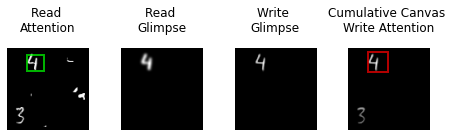

tensor([1.5928e-03, 4.3690e-04, 5.5451e-03, 5.0102e-03, 8.5090e-01, 1.7439e-03,
        1.5637e-03, 4.4682e-03, 3.8922e-03, 1.0499e-03, 1.3492e-04])
tensor([ 4,  2,  3,  7,  8,  5,  0,  6,  9,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([3.3309e-02, 1.8545e-01, 4.4374e-02, 1.1831e+00, 9.6311e-01, 1.3992e-01,
        8.3756e-02, 2.9973e-02, 3.0107e-02, 1.1089e-01, 2.9811e-04],
       device='cuda:0')
tensor([ 3,  4,  1,  5,  9,  6,  2,  0,  8,  7, 10], device='cuda:0')

****************************************************************************************************
trial 11

ground truth
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 4])
model prediction
tensor([1.1474, 0.0597, 0.0501, 0.0385, 0.9457, 0.0856, 0.0609, 0.0639, 0.0363,
        0.0665])
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 4])
partial score, 1.0, exact score, True


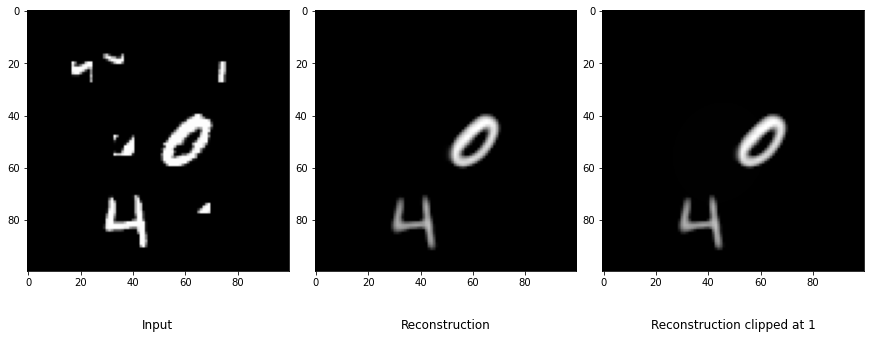

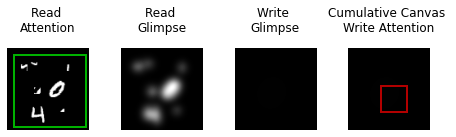

tensor([3.0816e-03, 4.6265e-03, 1.0077e-02, 1.6585e-02, 8.5245e-03, 8.1202e-02,
        1.2986e-02, 1.8387e-02, 9.9182e-03, 4.4917e-02, 3.6428e-06])
tensor([ 5,  9,  7,  3,  6,  2,  8,  4,  1,  0, 10])


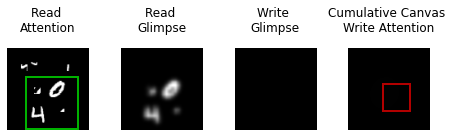

tensor([1.2520e-01, 4.9875e-02, 2.9205e-02, 8.8742e-03, 6.0910e-02, 1.6275e-03,
        4.1517e-02, 2.7192e-02, 3.9902e-03, 1.1184e-02, 2.1847e-05])
tensor([ 0,  4,  1,  6,  2,  7,  9,  3,  8,  5, 10])


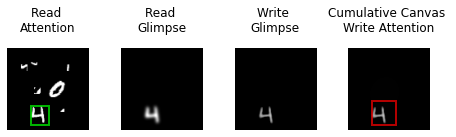

tensor([2.3474e-03, 1.5393e-03, 2.9292e-03, 2.7403e-03, 8.1848e-01, 1.1055e-03,
        2.2720e-03, 7.9975e-03, 1.2748e-02, 7.4811e-03, 1.1031e-04])
tensor([ 4,  8,  7,  9,  2,  3,  0,  6,  1,  5, 10])


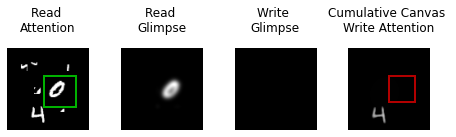

tensor([1.6663e-01, 1.4888e-03, 5.3121e-03, 7.5923e-03, 5.7040e-02, 8.8891e-04,
        1.8996e-03, 7.1562e-03, 5.9947e-03, 1.4450e-03, 1.5159e-05])
tensor([ 0,  4,  3,  7,  8,  2,  6,  1,  9,  5, 10])


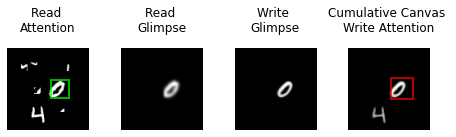

tensor([8.5014e-01, 2.1729e-03, 2.5270e-03, 2.7135e-03, 7.5831e-04, 8.0998e-04,
        2.2482e-03, 3.1834e-03, 3.6195e-03, 1.4518e-03, 8.1174e-05])
tensor([ 0,  8,  7,  3,  2,  6,  1,  9,  5,  4, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.1474e+00, 5.9703e-02, 5.0050e-02, 3.8505e-02, 9.4571e-01, 8.5634e-02,
        6.0923e-02, 6.3916e-02, 3.6270e-02, 6.6480e-02, 2.3213e-04],
       device='cuda:0')
tensor([ 0,  4,  5,  9,  7,  6,  1,  2,  3,  8, 10], device='cuda:0')

****************************************************************************************************
trial 12

ground truth
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 2])
model prediction
tensor([1.0276, 0.1170, 0.8290, 0.1208, 0.1336, 0.0952, 0.0382, 0.0618, 0.0649,
        0.1331])
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 2])
partial score, 1.0, exact score, True


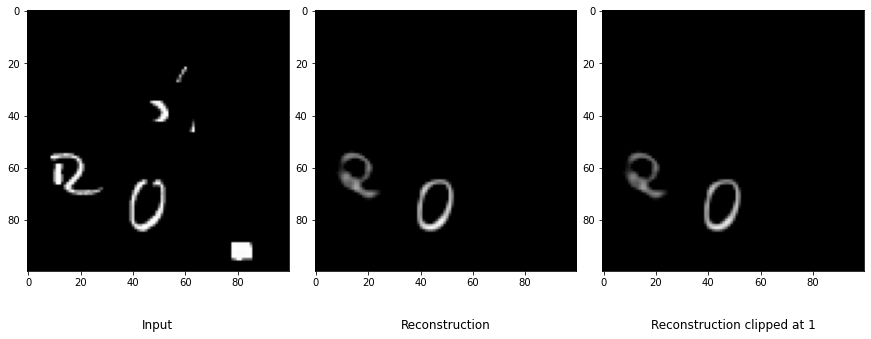

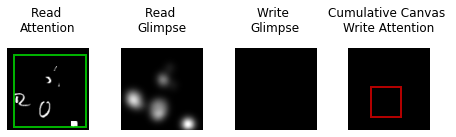

tensor([3.6072e-03, 2.7710e-03, 6.7642e-03, 4.1916e-02, 5.6296e-03, 8.1749e-02,
        4.4247e-03, 7.1741e-03, 2.2925e-02, 1.1851e-01, 6.3077e-06])
tensor([ 9,  5,  3,  8,  7,  2,  4,  6,  0,  1, 10])


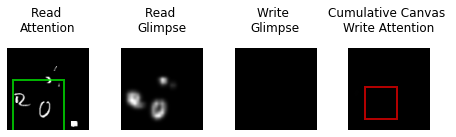

tensor([4.6928e-02, 1.0889e-01, 4.9240e-02, 6.6657e-02, 1.0961e-01, 7.7785e-03,
        1.6718e-02, 2.5789e-02, 9.1088e-03, 2.3759e-03, 3.2647e-05])
tensor([ 4,  1,  3,  2,  0,  7,  6,  8,  5,  9, 10])


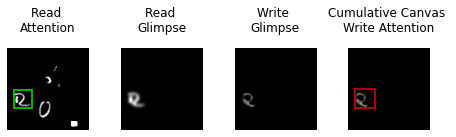

tensor([1.5797e-02, 1.8698e-03, 7.4309e-01, 4.7723e-03, 8.8322e-03, 3.0480e-03,
        6.3186e-03, 8.9041e-03, 1.3063e-02, 5.6223e-03, 4.6240e-05])
tensor([ 2,  0,  8,  7,  4,  6,  9,  3,  5,  1, 10])


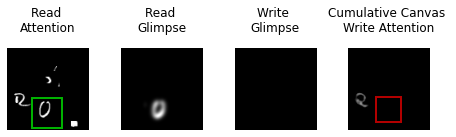

tensor([1.8980e-01, 5.8287e-04, 2.4085e-02, 3.0536e-03, 3.9458e-03, 1.7189e-03,
        3.2551e-03, 1.0477e-02, 1.5314e-02, 2.3975e-03, 7.0614e-06])
tensor([ 0,  2,  8,  7,  4,  6,  3,  9,  5,  1, 10])


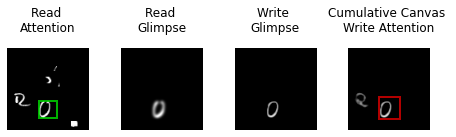

tensor([7.7146e-01, 2.8959e-03, 5.8309e-03, 4.3618e-03, 5.5422e-03, 8.6273e-04,
        7.4725e-03, 9.4509e-03, 4.4461e-03, 4.2120e-03, 8.5157e-05])
tensor([ 0,  7,  6,  2,  4,  8,  3,  9,  1,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0276e+00, 1.1701e-01, 8.2901e-01, 1.2076e-01, 1.3356e-01, 9.5157e-02,
        3.8189e-02, 6.1795e-02, 6.4857e-02, 1.3312e-01, 1.7741e-04],
       device='cuda:0')
tensor([ 0,  2,  4,  9,  3,  1,  5,  8,  7,  6, 10], device='cuda:0')

****************************************************************************************************
trial 13

ground truth
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([5, 7])
model prediction
tensor([0.1192, 0.1443, 0.1758, 0.1233, 0.0893, 1.0976, 0.0654, 0.8464, 0.0822,
        0.0970])
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([5, 7])
partial score, 1.0, exact score, True


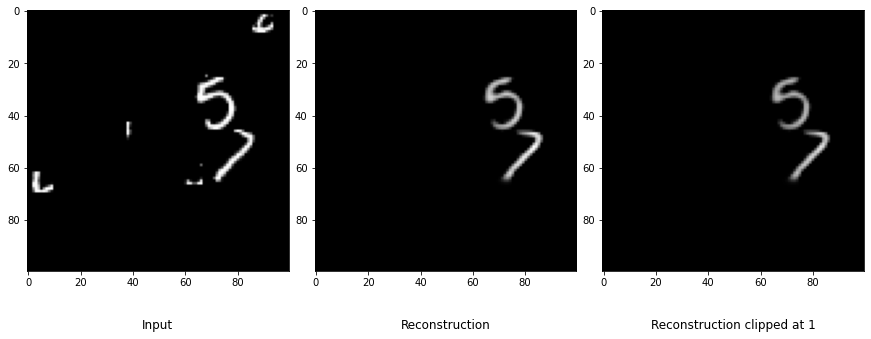

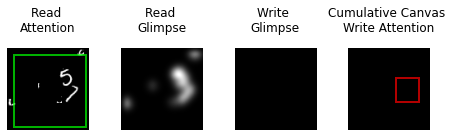

tensor([8.9607e-03, 8.9452e-03, 1.0311e-02, 3.1531e-02, 5.5068e-03, 1.2816e-01,
        6.6970e-03, 1.1892e-02, 1.2823e-02, 8.0345e-02, 3.7383e-06])
tensor([ 5,  9,  3,  8,  7,  2,  0,  1,  6,  4, 10])


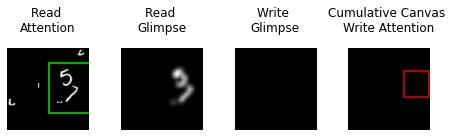

tensor([9.5488e-02, 8.6148e-02, 3.4943e-02, 4.0031e-02, 6.7005e-02, 1.0349e-02,
        5.0264e-02, 1.8797e-02, 1.7959e-02, 5.3942e-03, 2.7925e-05])
tensor([ 0,  1,  4,  6,  3,  2,  7,  8,  5,  9, 10])


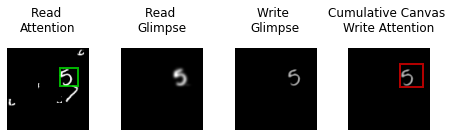

tensor([2.6354e-03, 1.9448e-03, 2.9783e-02, 4.8148e-03, 2.8353e-03, 7.9810e-01,
        2.4559e-03, 1.3930e-02, 1.0929e-02, 3.0615e-03, 7.3436e-05])
tensor([ 5,  2,  7,  8,  3,  9,  4,  0,  6,  1, 10])


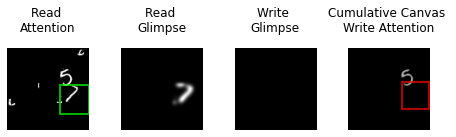

tensor([7.1413e-03, 5.4397e-03, 8.7939e-02, 4.2279e-02, 8.3419e-03, 1.6037e-01,
        3.5009e-03, 2.0099e-02, 3.6881e-02, 5.3681e-03, 1.9910e-05])
tensor([ 5,  2,  3,  8,  7,  4,  0,  1,  9,  6, 10])


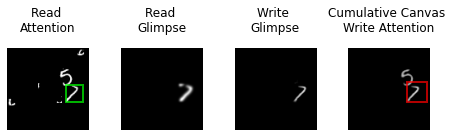

tensor([5.0112e-03, 4.1838e-02, 1.2823e-02, 4.6475e-03, 5.6215e-03, 6.3784e-04,
        2.4535e-03, 7.8169e-01, 3.6225e-03, 2.8707e-03, 5.8923e-05])
tensor([ 7,  1,  2,  4,  0,  3,  8,  9,  6,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.1924e-01, 1.4432e-01, 1.7580e-01, 1.2330e-01, 8.9310e-02, 1.0976e+00,
        6.5371e-02, 8.4641e-01, 8.2214e-02, 9.7040e-02, 1.8393e-04],
       device='cuda:0')
tensor([ 5,  7,  2,  1,  3,  0,  9,  4,  8,  6, 10], device='cuda:0')

****************************************************************************************************
trial 14

ground truth
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
tensor([5, 6])
model prediction
tensor([0.0734, 0.1014, 0.1481, 0.0838, 0.0761, 0.8633, 1.3533, 0.0802, 0.0572,
        0.0860])
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
tensor([5, 6])
partial score, 1.0, exact score, True


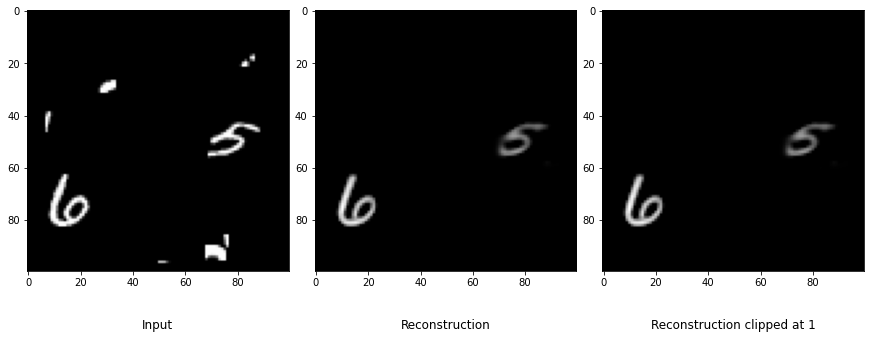

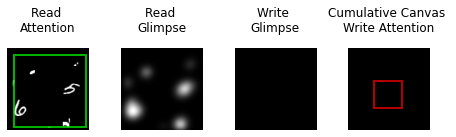

tensor([9.4603e-03, 1.5800e-03, 7.9228e-03, 1.4159e-02, 3.5298e-03, 1.0577e-01,
        1.5804e-02, 1.2489e-02, 2.5955e-02, 7.4470e-02, 2.8757e-06])
tensor([ 5,  9,  8,  6,  3,  7,  0,  2,  4,  1, 10])


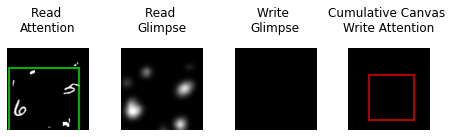

tensor([5.1049e-02, 9.6612e-02, 8.4801e-02, 5.1320e-02, 6.7074e-02, 2.4141e-02,
        1.2839e-01, 4.6612e-02, 2.7879e-03, 7.1331e-03, 4.3620e-05])
tensor([ 6,  1,  2,  4,  3,  0,  7,  5,  9,  8, 10])


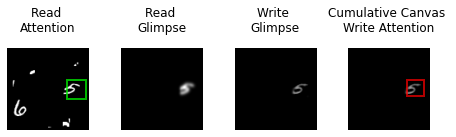

tensor([4.6753e-03, 4.1396e-04, 3.8412e-02, 4.6587e-03, 1.3042e-03, 7.2994e-01,
        2.2957e-03, 7.3556e-03, 1.9348e-02, 1.9083e-03, 1.2823e-04])
tensor([ 5,  2,  8,  7,  0,  3,  6,  9,  4,  1, 10])


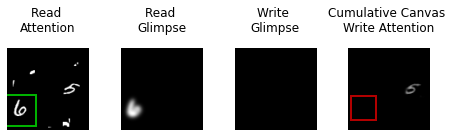

tensor([1.1172e-03, 1.7585e-03, 1.1024e-02, 8.6280e-03, 6.2677e-04, 1.9735e-03,
        3.5059e-01, 8.8738e-03, 5.5883e-03, 8.6539e-04, 3.0046e-05])
tensor([ 6,  2,  7,  3,  8,  5,  1,  0,  9,  4, 10])


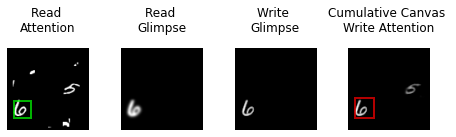

tensor([7.1430e-03, 1.0641e-03, 5.9682e-03, 5.0331e-03, 3.5659e-03, 1.5097e-03,
        8.5617e-01, 4.8908e-03, 3.4783e-03, 1.6460e-03, 2.8328e-04])
tensor([ 6,  0,  2,  3,  7,  4,  8,  9,  5,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.3445e-02, 1.0143e-01, 1.4813e-01, 8.3799e-02, 7.6100e-02, 8.6333e-01,
        1.3533e+00, 8.0222e-02, 5.7157e-02, 8.6022e-02, 4.8806e-04],
       device='cuda:0')
tensor([ 6,  5,  2,  1,  9,  3,  7,  4,  0,  8, 10], device='cuda:0')

****************************************************************************************************
trial 15

ground truth
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([5, 7])
model prediction
tensor([0.1427, 0.1023, 0.1347, 0.1078, 0.1137, 0.8365, 0.8736, 1.0021, 0.0843,
        0.0757])
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])
tensor([6, 7])
partial score, 0.5, exact score, False


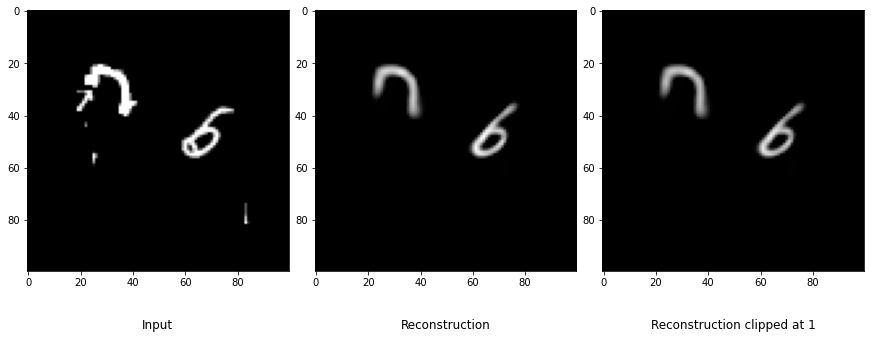

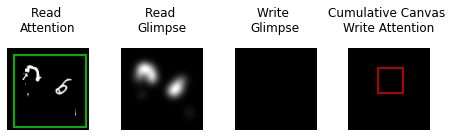

tensor([2.4207e-03, 7.7013e-03, 5.5611e-03, 1.9119e-02, 1.7194e-03, 1.0593e-01,
        2.9692e-03, 3.7641e-03, 2.0744e-02, 5.7184e-02, 4.2934e-06])
tensor([ 5,  9,  8,  3,  1,  2,  7,  6,  0,  4, 10])


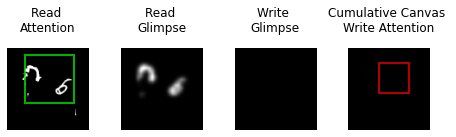

tensor([8.3388e-02, 8.4568e-02, 8.2905e-02, 6.3846e-02, 1.0291e-01, 7.5222e-03,
        6.9605e-02, 5.7634e-02, 1.4853e-02, 5.8496e-03, 5.6025e-05])
tensor([ 4,  1,  0,  2,  6,  3,  7,  8,  5,  9, 10])


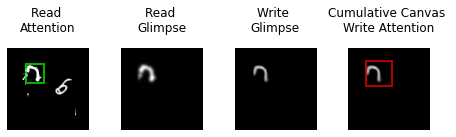

tensor([1.7802e-02, 2.5631e-03, 2.6177e-02, 1.0218e-02, 2.7627e-03, 2.5373e-03,
        6.7517e-03, 8.1459e-01, 1.5009e-02, 4.4965e-03, 1.2977e-04])
tensor([ 7,  2,  0,  8,  3,  6,  9,  4,  1,  5, 10])


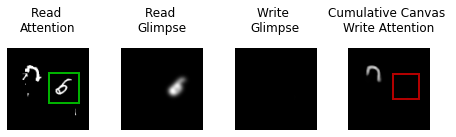

tensor([2.7956e-02, 4.1831e-03, 1.0016e-02, 7.9187e-03, 9.9221e-04, 3.8246e-02,
        7.6274e-02, 1.1858e-01, 7.5847e-03, 5.0704e-03, 1.4129e-05])
tensor([ 7,  6,  5,  0,  2,  3,  8,  9,  1,  4, 10])


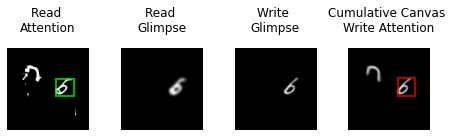

tensor([1.1171e-02, 3.3111e-03, 1.0089e-02, 6.7071e-03, 5.2837e-03, 6.8231e-01,
        7.1800e-01, 7.5208e-03, 2.6105e-02, 3.1143e-03, 1.0095e-04])
tensor([ 6,  5,  8,  0,  2,  7,  3,  4,  1,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.4274e-01, 1.0233e-01, 1.3475e-01, 1.0781e-01, 1.1367e-01, 8.3655e-01,
        8.7360e-01, 1.0021e+00, 8.4296e-02, 7.5715e-02, 3.0517e-04],
       device='cuda:0')
tensor([ 7,  6,  5,  0,  2,  4,  3,  1,  8,  9, 10], device='cuda:0')

****************************************************************************************************
trial 16

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
model prediction
tensor([0.0837, 1.0712, 0.1029, 0.0960, 0.0263, 0.0994, 0.0957, 0.1326, 0.0822,
        1.1979])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
partial score, 1.0, exact score, True


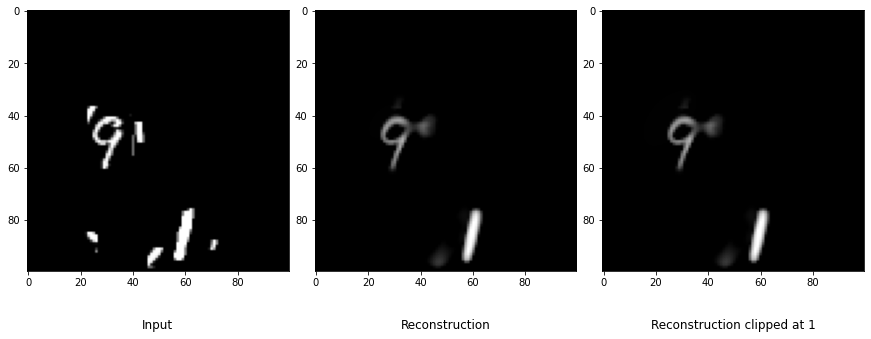

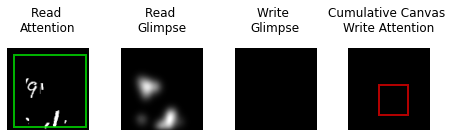

tensor([5.5455e-03, 5.6372e-03, 3.3285e-02, 4.3954e-02, 4.3923e-03, 9.3393e-02,
        5.7744e-02, 1.3593e-02, 4.6458e-02, 9.2188e-02, 4.2165e-06])
tensor([ 5,  9,  6,  8,  3,  2,  7,  1,  0,  4, 10])


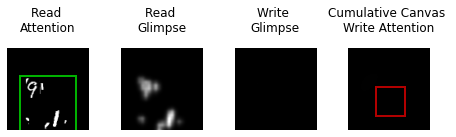

tensor([5.8476e-02, 1.9643e-01, 4.7160e-02, 1.3443e-02, 1.5351e-02, 2.9317e-03,
        3.0941e-02, 3.0655e-02, 1.3699e-02, 1.1230e-02, 3.5055e-05])
tensor([ 1,  0,  2,  6,  7,  4,  8,  3,  9,  5, 10])


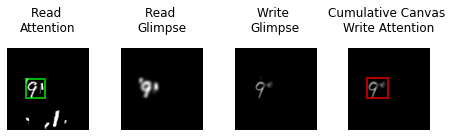

tensor([2.6054e-03, 2.2254e-03, 5.4198e-03, 4.5679e-03, 2.4451e-03, 1.1609e-03,
        1.8917e-03, 7.2180e-02, 3.6734e-03, 8.4579e-01, 1.5828e-04])
tensor([ 9,  7,  2,  3,  8,  0,  4,  1,  6,  5, 10])


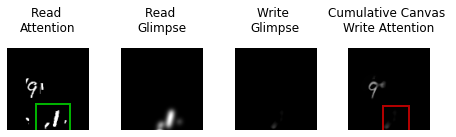

tensor([1.5015e-02, 2.8289e-02, 4.1632e-03, 9.3418e-03, 2.0582e-03, 1.0949e-03,
        2.7691e-03, 1.4438e-03, 2.3285e-03, 2.4442e-01, 2.7283e-05])
tensor([ 9,  1,  0,  3,  2,  6,  8,  4,  7,  5, 10])


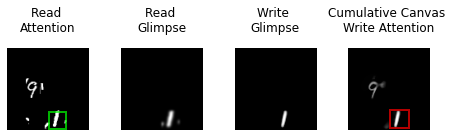

tensor([2.0854e-03, 8.3862e-01, 1.2881e-02, 2.4658e-02, 2.0056e-03, 7.8931e-04,
        2.3909e-03, 1.4682e-02, 1.6036e-02, 4.2469e-03, 1.2103e-04])
tensor([ 1,  3,  8,  7,  2,  9,  6,  0,  4,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([8.3727e-02, 1.0712e+00, 1.0291e-01, 9.5965e-02, 2.6252e-02, 9.9369e-02,
        9.5737e-02, 1.3255e-01, 8.2196e-02, 1.1979e+00, 3.4587e-04],
       device='cuda:0')
tensor([ 9,  1,  7,  2,  5,  3,  6,  0,  8,  4, 10], device='cuda:0')

****************************************************************************************************
trial 17

ground truth
tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])
tensor([6, 8])
model prediction
tensor([0.0401, 0.1462, 0.0515, 0.0529, 0.0698, 0.1235, 0.9242, 0.0500, 1.3011,
        0.0545])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])
tensor([6, 8])
partial score, 1.0, exact score, True


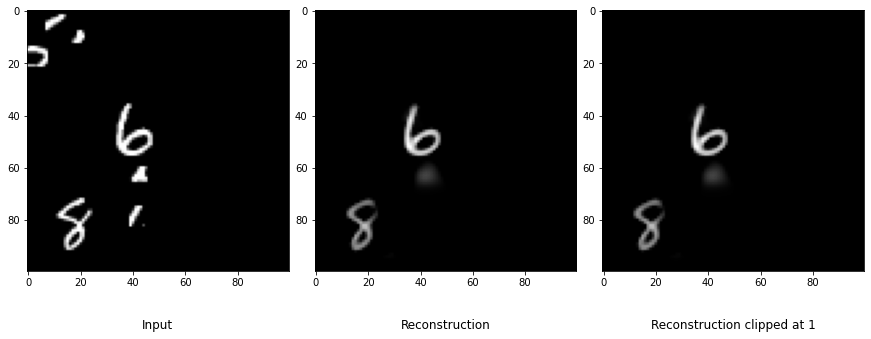

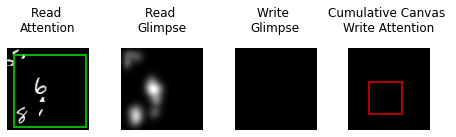

tensor([1.9759e-03, 4.2759e-03, 8.3838e-03, 2.4236e-02, 1.7285e-03, 1.0510e-01,
        1.2262e-03, 1.5107e-03, 1.3297e-02, 3.3735e-02, 7.1094e-06])
tensor([ 5,  9,  3,  8,  2,  1,  0,  4,  7,  6, 10])


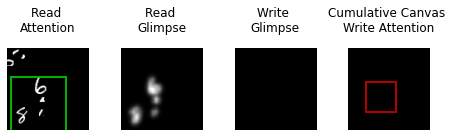

tensor([3.0732e-02, 1.3316e-01, 1.4985e-02, 6.1188e-03, 5.6274e-02, 1.0812e-02,
        2.0032e-02, 1.9151e-02, 1.2879e-02, 9.9654e-03, 6.0564e-06])
tensor([ 1,  4,  0,  6,  7,  2,  8,  5,  9,  3, 10])


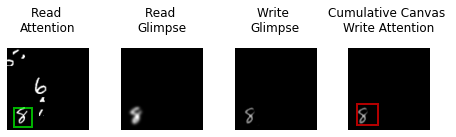

tensor([3.1960e-03, 4.8122e-03, 8.0753e-03, 1.5904e-02, 9.3229e-03, 3.9848e-03,
        1.5391e-02, 9.2432e-03, 8.4109e-01, 7.4980e-03, 2.0012e-04])
tensor([ 8,  3,  6,  4,  7,  2,  9,  1,  5,  0, 10])


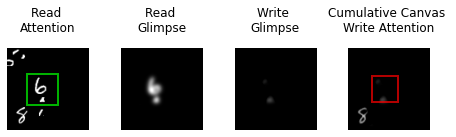

tensor([2.4474e-03, 2.3693e-03, 9.2980e-03, 2.2192e-03, 1.4004e-03, 2.4016e-03,
        3.9331e-03, 7.8689e-03, 4.1577e-01, 2.2155e-03, 6.9401e-05])
tensor([ 8,  2,  7,  6,  0,  5,  1,  3,  9,  4, 10])


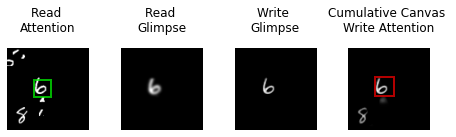

tensor([1.7715e-03, 1.5667e-03, 1.0715e-02, 4.4165e-03, 1.1087e-03, 1.1619e-03,
        8.8363e-01, 1.2250e-02, 1.8020e-02, 1.0494e-03, 3.2016e-04])
tensor([ 6,  8,  7,  2,  3,  0,  1,  5,  4,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([4.0123e-02, 1.4618e-01, 5.1458e-02, 5.2895e-02, 6.9835e-02, 1.2346e-01,
        9.2421e-01, 5.0024e-02, 1.3011e+00, 5.4464e-02, 6.0286e-04],
       device='cuda:0')
tensor([ 8,  6,  1,  5,  4,  9,  3,  2,  7,  0, 10], device='cuda:0')

****************************************************************************************************
trial 18

ground truth
tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 5])
model prediction
tensor([0.0868, 1.0367, 0.1225, 0.0612, 0.0354, 1.2230, 0.1081, 0.0643, 0.0669,
        0.1130])
tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 5])
partial score, 1.0, exact score, True


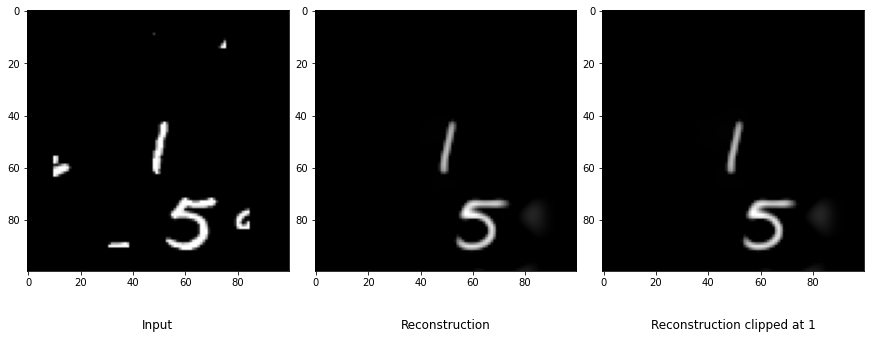

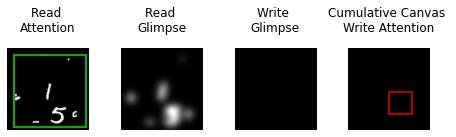

tensor([9.6374e-03, 7.2681e-03, 1.6146e-02, 2.3494e-02, 7.3145e-03, 8.7825e-02,
        5.7629e-02, 2.5501e-02, 4.0439e-02, 9.9029e-02, 4.2673e-06])
tensor([ 9,  5,  6,  8,  7,  3,  2,  0,  4,  1, 10])


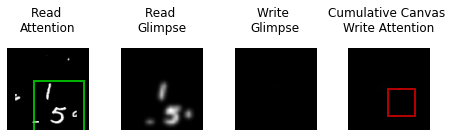

tensor([6.0580e-02, 1.7256e-01, 3.3642e-02, 1.1012e-02, 2.2836e-02, 3.6658e-03,
        2.1949e-02, 1.8434e-02, 9.5604e-03, 9.1929e-03, 1.8740e-05])
tensor([ 1,  0,  2,  4,  6,  7,  3,  8,  9,  5, 10])


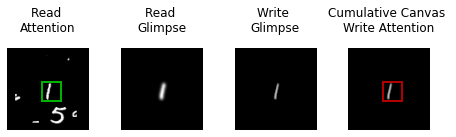

tensor([1.0625e-03, 7.8978e-01, 5.2018e-03, 3.9933e-03, 2.1520e-03, 7.4451e-04,
        1.7012e-03, 1.5809e-03, 7.3986e-03, 5.3859e-04, 6.2186e-05])
tensor([ 1,  8,  2,  3,  4,  6,  7,  0,  5,  9, 10])


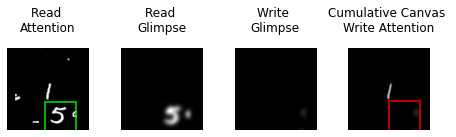

tensor([1.4334e-02, 6.4778e-02, 6.5284e-02, 1.6479e-02, 1.1282e-03, 2.6056e-01,
        1.7379e-02, 1.6034e-02, 5.0234e-03, 1.9514e-03, 3.1073e-05])
tensor([ 5,  2,  1,  6,  3,  7,  0,  8,  9,  4, 10])


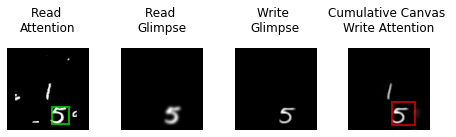

tensor([1.1362e-03, 2.3153e-03, 2.2712e-03, 6.2443e-03, 1.9979e-03, 8.7021e-01,
        9.4883e-03, 2.7237e-03, 4.4875e-03, 2.3218e-03, 2.6651e-04])
tensor([ 5,  6,  3,  8,  7,  9,  1,  2,  4,  0, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([8.6750e-02, 1.0367e+00, 1.2254e-01, 6.1223e-02, 3.5429e-02, 1.2230e+00,
        1.0815e-01, 6.4273e-02, 6.6909e-02, 1.1303e-01, 3.8277e-04],
       device='cuda:0')
tensor([ 5,  1,  2,  9,  6,  0,  8,  7,  3,  4, 10], device='cuda:0')

****************************************************************************************************
trial 19

ground truth
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
tensor([3, 4])
model prediction
tensor([0.1554, 0.1370, 0.0637, 0.8868, 1.0118, 0.1531, 0.0768, 0.0385, 0.0984,
        0.1452])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
tensor([3, 4])
partial score, 1.0, exact score, True


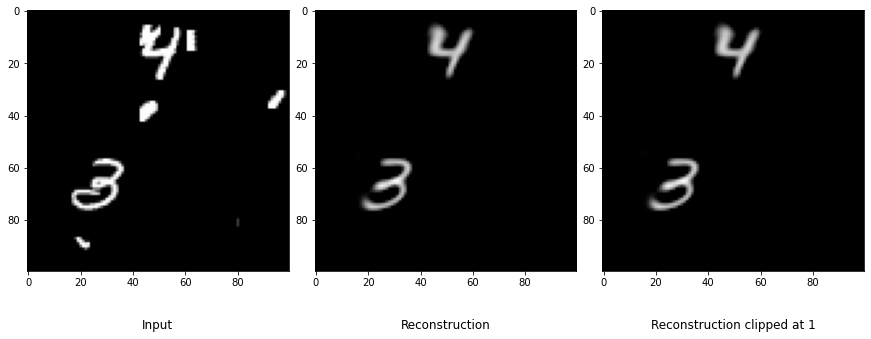

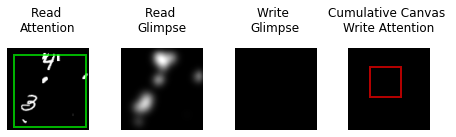

tensor([6.6643e-03, 1.9111e-02, 7.0339e-03, 1.8437e-02, 1.4998e-03, 1.0098e-01,
        1.0704e-03, 9.0034e-03, 2.5653e-02, 2.2559e-02, 6.6476e-06])
tensor([ 5,  8,  9,  1,  3,  7,  2,  0,  4,  6, 10])


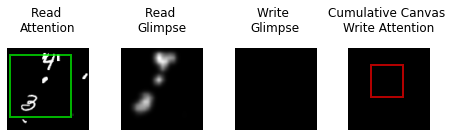

tensor([1.3898e-01, 1.1249e-01, 1.7362e-02, 2.6666e-02, 8.7633e-02, 4.5282e-02,
        6.5291e-02, 1.5294e-02, 3.0028e-02, 1.1111e-01, 2.7183e-05])
tensor([ 0,  1,  9,  4,  6,  5,  8,  3,  2,  7, 10])


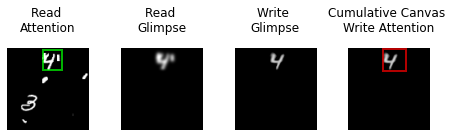

tensor([2.9661e-03, 9.6934e-04, 5.2337e-03, 4.8285e-03, 8.1702e-01, 1.6661e-03,
        7.4823e-03, 6.8952e-03, 1.0095e-02, 7.1740e-03, 9.9777e-05])
tensor([ 4,  8,  6,  9,  7,  2,  3,  0,  5,  1, 10])


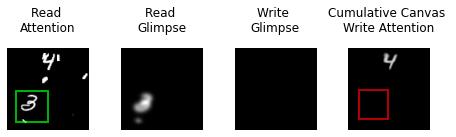

tensor([2.3291e-03, 2.1962e-03, 8.4553e-03, 2.1976e-02, 1.0432e-01, 3.8679e-03,
        1.1496e-03, 3.6255e-03, 1.8444e-02, 8.6692e-04, 1.4089e-05])
tensor([ 4,  3,  8,  2,  5,  7,  0,  1,  6,  9, 10])


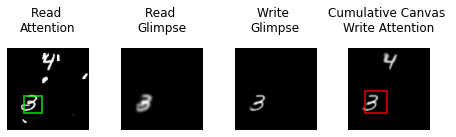

tensor([4.4185e-03, 2.2483e-03, 2.5572e-02, 8.1490e-01, 1.2978e-03, 1.2610e-03,
        1.8154e-03, 3.6535e-03, 1.4223e-02, 3.4420e-03, 1.3798e-04])
tensor([ 3,  2,  8,  0,  7,  9,  1,  6,  4,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.5535e-01, 1.3701e-01, 6.3657e-02, 8.8680e-01, 1.0118e+00, 1.5306e-01,
        7.6808e-02, 3.8472e-02, 9.8443e-02, 1.4516e-01, 2.8568e-04],
       device='cuda:0')
tensor([ 4,  3,  0,  5,  9,  1,  8,  6,  2,  7, 10], device='cuda:0')

****************************************************************************************************
trial 20

ground truth
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
tensor([2, 9])
model prediction
tensor([0.0714, 0.1424, 1.1708, 0.1274, 0.6567, 0.5532, 0.0443, 0.1860, 0.1139,
        0.1959])
tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([2, 4])
partial score, 0.5, exact score, False


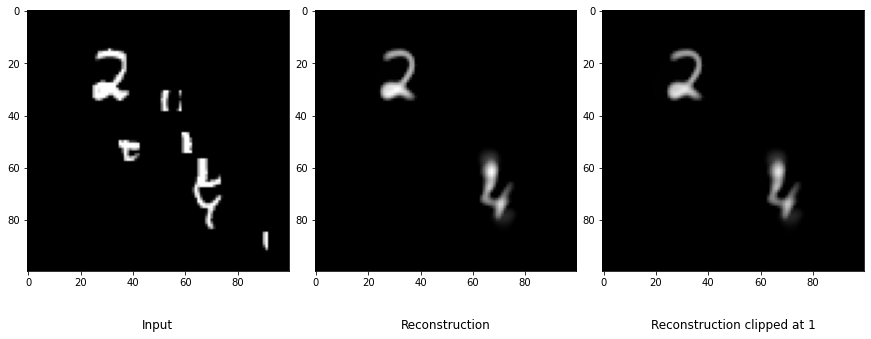

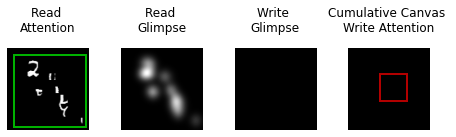

tensor([3.9097e-03, 1.0443e-02, 3.9486e-03, 1.5463e-02, 6.0161e-03, 5.1491e-02,
        1.2935e-02, 3.2382e-03, 1.8719e-02, 6.4381e-02, 4.8494e-06])
tensor([ 9,  5,  8,  3,  6,  1,  4,  2,  0,  7, 10])


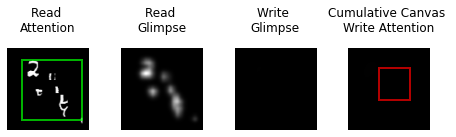

tensor([5.6472e-02, 1.1657e-01, 6.4738e-02, 8.2648e-02, 8.9497e-02, 1.9569e-02,
        1.1026e-02, 3.0780e-02, 5.7816e-02, 4.4327e-02, 2.6682e-05])
tensor([ 1,  4,  3,  2,  8,  0,  9,  7,  5,  6, 10])


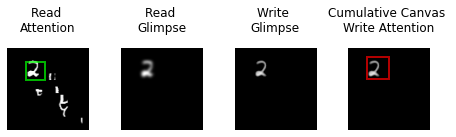

tensor([1.0297e-03, 4.4212e-03, 8.3538e-01, 2.6497e-03, 4.2759e-04, 1.9580e-03,
        1.2164e-03, 1.0768e-02, 4.9699e-03, 1.2493e-03, 1.4772e-04])
tensor([ 2,  7,  8,  1,  3,  5,  9,  6,  0,  4, 10])


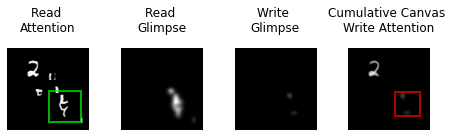

tensor([1.6843e-03, 3.2314e-03, 2.3228e-01, 4.2683e-03, 1.2871e-03, 1.5046e-03,
        5.8554e-03, 1.5308e-02, 1.4451e-02, 4.7857e-03, 1.5741e-05])
tensor([ 2,  7,  8,  6,  9,  3,  1,  0,  5,  4, 10])


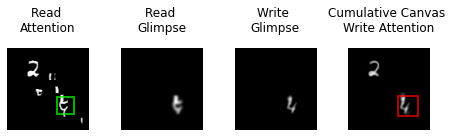

tensor([8.2916e-03, 7.7818e-03, 3.4428e-02, 2.2341e-02, 5.5951e-01, 4.7870e-01,
        1.3288e-02, 1.2592e-01, 1.7915e-02, 8.1144e-02, 9.0618e-05])
tensor([ 4,  5,  7,  9,  2,  3,  8,  6,  0,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.1387e-02, 1.4244e-01, 1.1708e+00, 1.2737e-01, 6.5673e-01, 5.5322e-01,
        4.4321e-02, 1.8601e-01, 1.1387e-01, 1.9589e-01, 2.8561e-04],
       device='cuda:0')
tensor([ 2,  4,  5,  9,  7,  1,  3,  8,  0,  6, 10], device='cuda:0')

****************************************************************************************************
trial 21

ground truth
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])
tensor([5, 9])
model prediction
tensor([0.1559, 0.1638, 0.1541, 0.2355, 0.0798, 0.8697, 0.0943, 0.0641, 0.8100,
        0.3528])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0])
tensor([5, 8])
partial score, 0.5, exact score, False


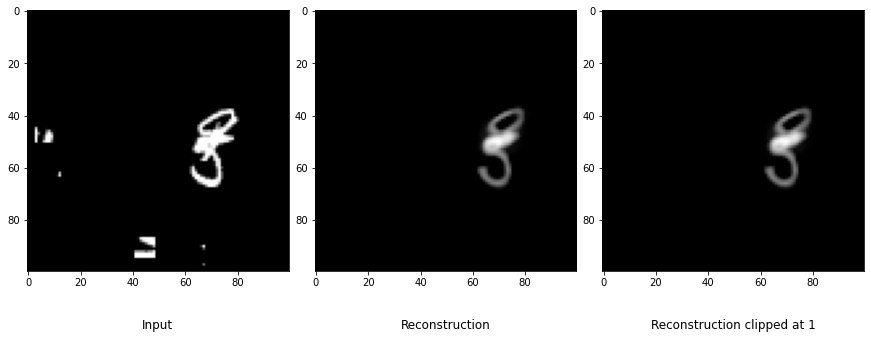

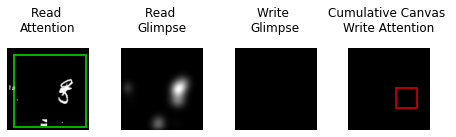

tensor([9.8255e-03, 1.4023e-02, 7.5721e-03, 3.4128e-02, 1.1014e-02, 1.3417e-01,
        1.4592e-02, 1.3006e-02, 1.4338e-02, 1.2493e-01, 7.3897e-06])
tensor([ 5,  9,  3,  6,  8,  1,  7,  4,  0,  2, 10])


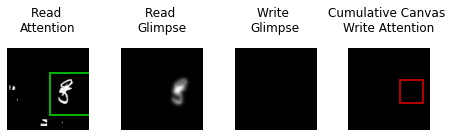

tensor([7.5564e-02, 1.3609e-01, 5.1847e-03, 1.0721e-02, 5.1371e-02, 3.7368e-02,
        6.2813e-02, 2.2498e-02, 8.2657e-03, 2.2003e-03, 6.0558e-06])
tensor([ 1,  0,  6,  4,  5,  7,  3,  8,  2,  9, 10])


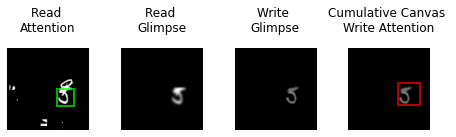

tensor([6.6477e-03, 2.6555e-03, 8.5997e-03, 1.2491e-01, 4.3066e-03, 6.2905e-01,
        8.8443e-03, 4.5393e-03, 2.5227e-02, 2.0651e-03, 9.7066e-05])
tensor([ 5,  3,  8,  6,  2,  0,  7,  4,  1,  9, 10])


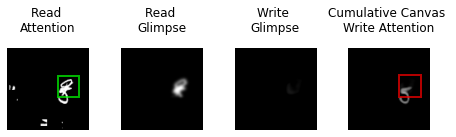

tensor([6.0701e-02, 8.9417e-03, 4.0353e-02, 4.5800e-02, 1.1409e-02, 6.8594e-02,
        4.1491e-03, 2.2740e-02, 6.2952e-02, 2.4770e-02, 1.3629e-05])
tensor([ 5,  8,  0,  3,  2,  9,  7,  4,  1,  6, 10])


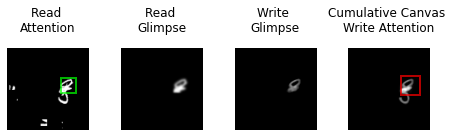

tensor([3.1258e-03, 2.1103e-03, 9.2378e-02, 1.9904e-02, 1.6764e-03, 5.3236e-04,
        3.8664e-03, 1.2877e-03, 6.9921e-01, 1.9886e-01, 7.3224e-05])
tensor([ 8,  9,  2,  3,  6,  0,  1,  4,  7,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.5586e-01, 1.6382e-01, 1.5409e-01, 2.3547e-01, 7.9776e-02, 8.6972e-01,
        9.4265e-02, 6.4071e-02, 8.0999e-01, 3.5282e-01, 1.9737e-04],
       device='cuda:0')
tensor([ 5,  8,  9,  3,  1,  0,  2,  6,  4,  7, 10], device='cuda:0')

****************************************************************************************************
trial 22

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
model prediction
tensor([0.0768, 0.0188, 0.0778, 0.9080, 0.0975, 0.1089, 0.0826, 0.0570, 0.0666,
        1.0499])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
partial score, 1.0, exact score, True


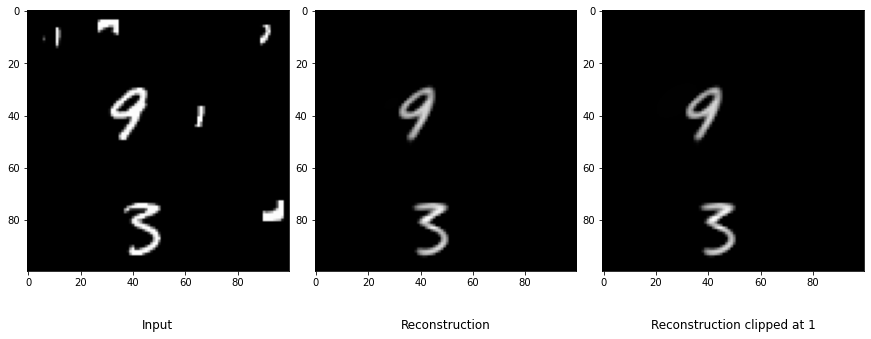

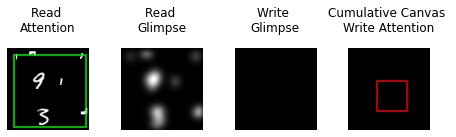

tensor([4.8762e-03, 7.0952e-03, 4.4338e-03, 1.1040e-02, 1.1978e-03, 8.8592e-02,
        1.5913e-02, 4.8497e-03, 1.5865e-02, 3.4344e-02, 6.9908e-06])
tensor([ 5,  9,  6,  8,  3,  1,  0,  7,  2,  4, 10])


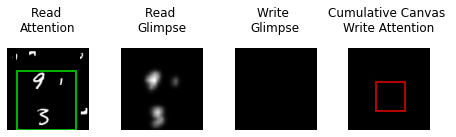

tensor([6.6326e-02, 8.7396e-03, 5.5669e-02, 1.1666e-02, 9.2426e-02, 1.2493e-02,
        5.8259e-02, 4.0295e-02, 3.6078e-02, 1.7153e-02, 3.1325e-05])
tensor([ 4,  0,  6,  2,  7,  8,  9,  5,  3,  1, 10])


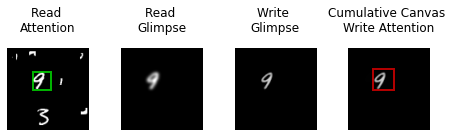

tensor([2.0048e-03, 1.4869e-03, 8.3567e-03, 2.1762e-03, 1.4245e-03, 1.6040e-03,
        2.6377e-03, 1.9640e-03, 2.6740e-03, 8.2632e-01, 1.4411e-04])
tensor([ 9,  2,  8,  6,  3,  0,  7,  5,  1,  4, 10])


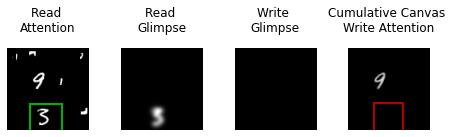

tensor([1.1159e-03, 4.1547e-04, 6.6993e-03, 1.4802e-02, 1.5186e-03, 3.6555e-03,
        1.5474e-03, 7.8886e-03, 6.7386e-03, 1.7139e-01, 2.9344e-05])
tensor([ 9,  3,  7,  8,  2,  5,  6,  4,  0,  1, 10])


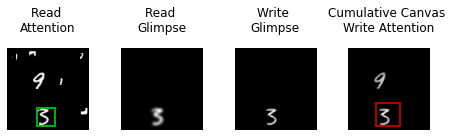

tensor([2.5253e-03, 1.0694e-03, 2.6181e-03, 8.6830e-01, 9.0154e-04, 2.5793e-03,
        4.2283e-03, 1.9534e-03, 5.2938e-03, 7.0558e-04, 1.5053e-04])
tensor([ 3,  8,  6,  2,  5,  0,  7,  1,  4,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.6849e-02, 1.8807e-02, 7.7776e-02, 9.0798e-01, 9.7468e-02, 1.0892e-01,
        8.2585e-02, 5.6951e-02, 6.6650e-02, 1.0499e+00, 3.6230e-04],
       device='cuda:0')
tensor([ 9,  3,  5,  4,  6,  2,  0,  8,  7,  1, 10], device='cuda:0')

****************************************************************************************************
trial 23

ground truth
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 3])
model prediction
tensor([0.9580, 0.1285, 0.0745, 1.2298, 0.1181, 0.1355, 0.1038, 0.1348, 0.0472,
        0.1129])
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 3])
partial score, 1.0, exact score, True


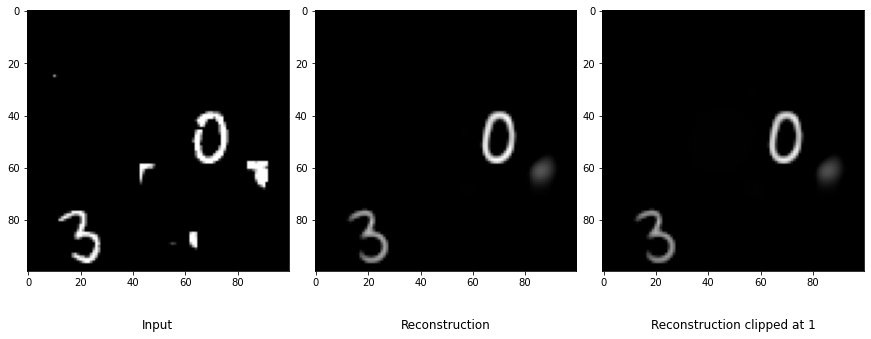

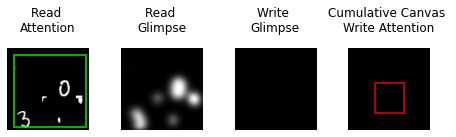

tensor([7.1852e-03, 8.7740e-03, 5.0572e-03, 1.1868e-02, 8.0887e-03, 8.5240e-02,
        1.4363e-02, 1.4633e-02, 1.0725e-02, 5.2813e-02, 4.0022e-06])
tensor([ 5,  9,  7,  6,  3,  8,  1,  4,  0,  2, 10])


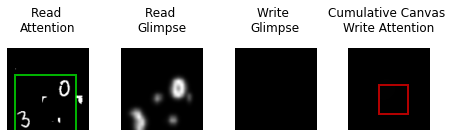

tensor([6.3894e-02, 8.4146e-02, 5.0177e-02, 3.7806e-02, 8.8619e-02, 4.4169e-02,
        8.0371e-02, 8.5825e-02, 8.0022e-03, 5.0493e-02, 4.0208e-05])
tensor([ 4,  7,  1,  6,  0,  9,  2,  5,  3,  8, 10])


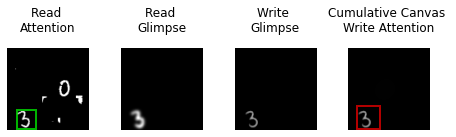

tensor([1.9861e-03, 2.7551e-03, 4.7711e-03, 8.0460e-01, 1.3832e-03, 1.8163e-03,
        4.6057e-03, 3.8983e-03, 1.0971e-02, 1.5885e-03, 7.3155e-05])
tensor([ 3,  8,  2,  6,  7,  1,  0,  5,  9,  4, 10])


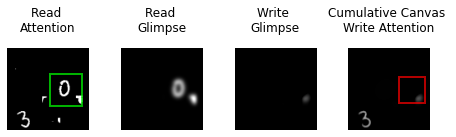

tensor([3.4883e-02, 3.0813e-02, 5.2548e-03, 3.7214e-01, 1.8540e-02, 2.1429e-03,
        2.3609e-03, 2.7180e-02, 1.1251e-02, 7.1739e-03, 6.1997e-05])
tensor([ 3,  0,  1,  7,  4,  8,  9,  2,  6,  5, 10])


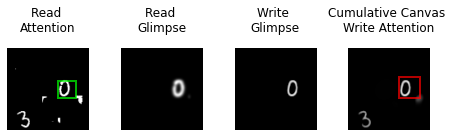

tensor([8.5009e-01, 2.0505e-03, 9.2782e-03, 3.3686e-03, 1.5074e-03, 2.0993e-03,
        2.1121e-03, 3.2300e-03, 6.2230e-03, 7.9586e-04, 1.1771e-04])
tensor([ 0,  2,  8,  3,  7,  6,  5,  1,  4,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([9.5804e-01, 1.2854e-01, 7.4538e-02, 1.2298e+00, 1.1814e-01, 1.3547e-01,
        1.0381e-01, 1.3477e-01, 4.7173e-02, 1.1286e-01, 2.9707e-04],
       device='cuda:0')
tensor([ 3,  0,  5,  7,  1,  4,  9,  6,  2,  8, 10], device='cuda:0')

****************************************************************************************************
trial 24

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 7])
model prediction
tensor([0.0785, 1.1156, 0.1134, 0.0469, 0.1099, 0.1076, 0.0998, 0.8427, 0.0477,
        0.0343])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 7])
partial score, 1.0, exact score, True


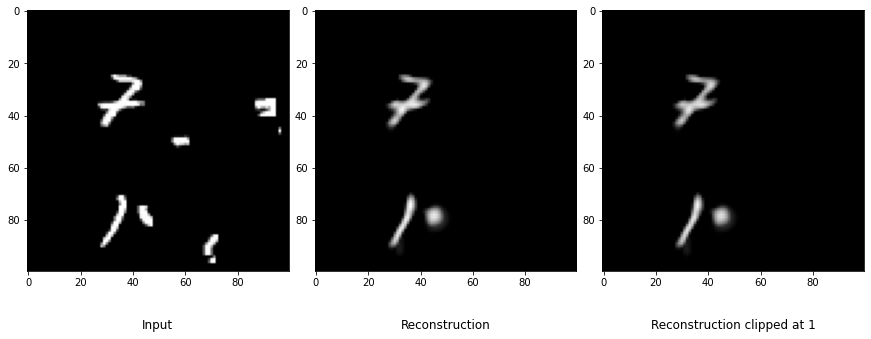

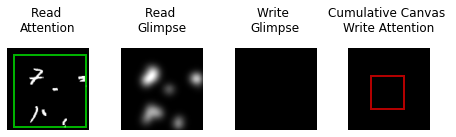

tensor([3.8952e-03, 7.4725e-03, 5.3251e-03, 1.1562e-02, 1.7965e-03, 8.2198e-02,
        4.1054e-03, 3.9118e-03, 1.3608e-02, 2.3248e-02, 5.4882e-06])
tensor([ 5,  9,  8,  3,  1,  2,  6,  7,  0,  4, 10])


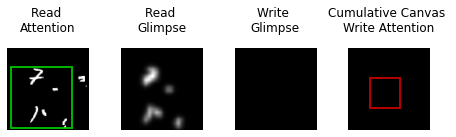

tensor([6.6671e-02, 8.4875e-02, 3.2562e-02, 6.8501e-03, 9.8166e-02, 2.5491e-03,
        6.9952e-02, 1.6899e-02, 1.3336e-02, 6.7191e-03, 2.9378e-05])
tensor([ 4,  1,  6,  0,  2,  7,  8,  3,  9,  5, 10])


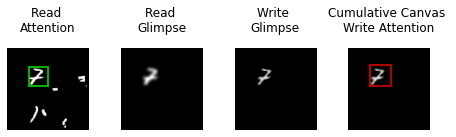

tensor([2.5942e-03, 2.3873e-03, 2.8674e-02, 6.0218e-03, 4.1874e-03, 3.1136e-03,
        1.8993e-03, 7.9108e-01, 2.7376e-03, 1.0324e-03, 4.8469e-05])
tensor([ 7,  2,  3,  4,  5,  8,  0,  1,  6,  9, 10])


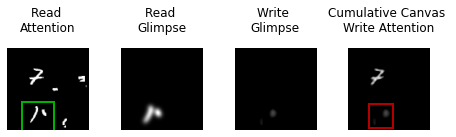

tensor([3.0004e-03, 1.9455e-01, 3.8009e-02, 1.3379e-02, 4.2315e-03, 1.6616e-02,
        7.6138e-03, 2.3284e-02, 7.9203e-03, 2.0833e-03, 2.5965e-05])
tensor([ 1,  2,  7,  5,  3,  8,  6,  4,  0,  9, 10])


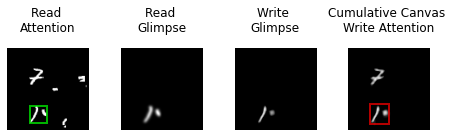

tensor([2.3719e-03, 8.2633e-01, 8.7984e-03, 9.0625e-03, 1.5642e-03, 3.1423e-03,
        1.6228e-02, 7.5096e-03, 1.0056e-02, 1.2322e-03, 7.7227e-05])
tensor([ 1,  6,  8,  3,  2,  7,  5,  0,  4,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.8533e-02, 1.1156e+00, 1.1337e-01, 4.6875e-02, 1.0995e-01, 1.0762e-01,
        9.9799e-02, 8.4268e-01, 4.7658e-02, 3.4315e-02, 1.8653e-04],
       device='cuda:0')
tensor([ 1,  7,  2,  4,  5,  6,  0,  8,  3,  9, 10], device='cuda:0')

****************************************************************************************************
trial 25

ground truth
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
tensor([7, 9])
model prediction
tensor([0.1225, 0.0426, 0.1123, 0.0442, 0.1257, 0.0861, 0.1103, 1.2188, 0.0783,
        0.9467])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
tensor([7, 9])
partial score, 1.0, exact score, True


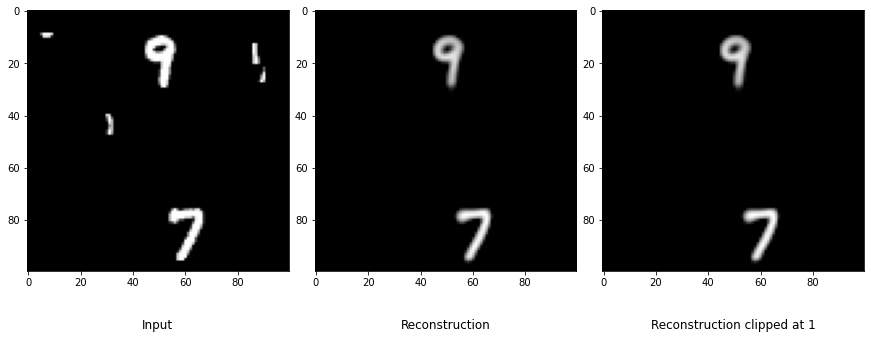

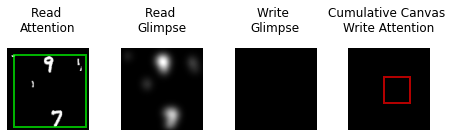

tensor([3.2193e-02, 3.1243e-02, 6.4861e-03, 1.6592e-02, 2.0192e-02, 7.5233e-02,
        4.4952e-02, 8.0609e-03, 2.6395e-02, 7.8031e-02, 6.8502e-06])
tensor([ 9,  5,  6,  0,  1,  8,  4,  3,  7,  2, 10])


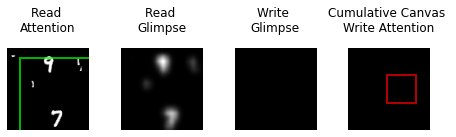

tensor([8.7042e-02, 9.0157e-03, 8.9906e-02, 1.4385e-02, 1.0237e-01, 6.3555e-03,
        5.9389e-02, 6.4394e-02, 3.3698e-02, 3.1859e-02, 4.0865e-05])
tensor([ 4,  2,  0,  7,  6,  8,  9,  3,  1,  5, 10])


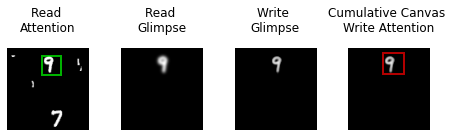

tensor([1.4401e-03, 6.6444e-04, 4.4525e-03, 2.6661e-03, 6.2275e-04, 1.1407e-03,
        3.3835e-03, 5.5353e-03, 8.5425e-03, 8.0918e-01, 1.1527e-04])
tensor([ 9,  8,  7,  2,  6,  3,  0,  5,  1,  4, 10])


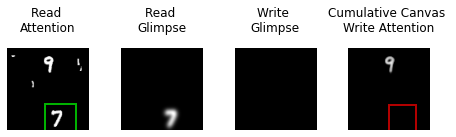

tensor([8.8375e-04, 4.7719e-04, 5.1569e-03, 6.1221e-03, 1.8896e-03, 1.5091e-03,
        1.2666e-03, 2.6588e-01, 4.5716e-03, 2.6660e-02, 1.6629e-05])
tensor([ 7,  9,  3,  2,  8,  4,  5,  6,  0,  1, 10])


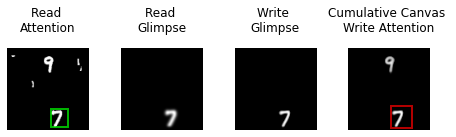

tensor([9.1507e-04, 1.2358e-03, 6.3300e-03, 4.4384e-03, 6.5051e-04, 1.8475e-03,
        1.2851e-03, 8.7489e-01, 5.1198e-03, 9.5058e-04, 1.1271e-04])
tensor([ 7,  2,  8,  3,  5,  6,  1,  9,  0,  4, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.2247e-01, 4.2636e-02, 1.1233e-01, 4.4204e-02, 1.2573e-01, 8.6085e-02,
        1.1028e-01, 1.2188e+00, 7.8327e-02, 9.4668e-01, 2.9232e-04],
       device='cuda:0')
tensor([ 7,  9,  4,  0,  2,  6,  5,  8,  3,  1, 10], device='cuda:0')

****************************************************************************************************
trial 26

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
model prediction
tensor([0.0678, 1.2799, 0.1140, 0.0678, 0.0544, 0.1267, 0.0616, 0.0616, 0.0711,
        0.9619])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
partial score, 1.0, exact score, True


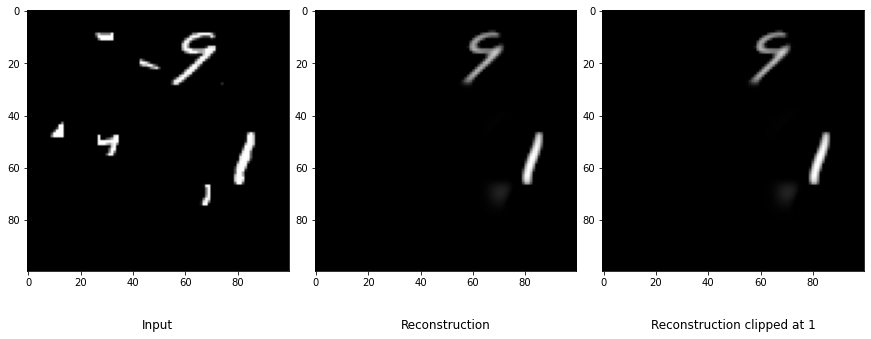

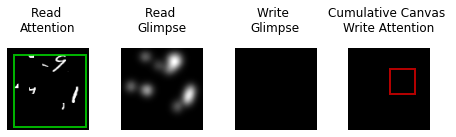

tensor([6.0502e-03, 1.2423e-02, 7.5403e-03, 3.2127e-02, 7.2103e-03, 1.1528e-01,
        8.7402e-03, 3.3606e-03, 1.9987e-02, 6.2886e-02, 3.2224e-06])
tensor([ 5,  9,  3,  8,  1,  6,  2,  4,  0,  7, 10])


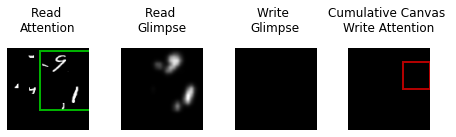

tensor([5.3408e-02, 1.7024e-01, 5.8250e-02, 1.3903e-02, 4.1450e-02, 3.4317e-03,
        4.3304e-02, 3.4876e-02, 2.5865e-02, 2.2607e-02, 3.3930e-05])
tensor([ 1,  2,  0,  6,  4,  7,  8,  9,  3,  5, 10])


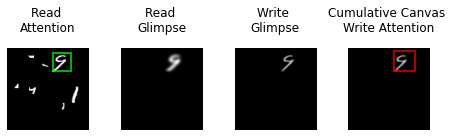

tensor([1.0665e-03, 9.3114e-04, 1.2395e-02, 7.1779e-03, 1.5407e-03, 6.1242e-03,
        1.9378e-03, 3.6460e-03, 2.1986e-03, 8.1823e-01, 9.8104e-05])
tensor([ 9,  2,  3,  5,  7,  8,  6,  4,  0,  1, 10])


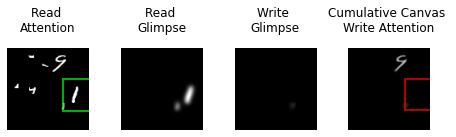

tensor([5.9208e-03, 2.3217e-01, 1.0119e-02, 2.5406e-03, 1.9858e-03, 6.7756e-04,
        2.5252e-03, 1.3571e-02, 1.2667e-02, 5.7292e-02, 1.5582e-05])
tensor([ 1,  9,  7,  8,  2,  0,  3,  6,  4,  5, 10])


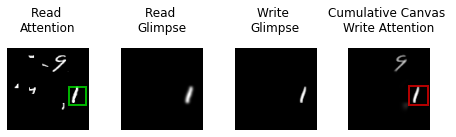

tensor([1.3942e-03, 8.6415e-01, 2.5719e-02, 1.2055e-02, 2.1714e-03, 1.1780e-03,
        5.0732e-03, 6.1066e-03, 1.0411e-02, 9.3510e-04, 1.8383e-04])
tensor([ 1,  2,  3,  8,  7,  6,  4,  0,  5,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([6.7840e-02, 1.2799e+00, 1.1402e-01, 6.7805e-02, 5.4358e-02, 1.2670e-01,
        6.1581e-02, 6.1560e-02, 7.1128e-02, 9.6195e-01, 3.3467e-04],
       device='cuda:0')
tensor([ 1,  9,  5,  2,  8,  0,  3,  6,  7,  4, 10], device='cuda:0')

****************************************************************************************************
trial 27

ground truth
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor([6, 9])
model prediction
tensor([0.0722, 0.0913, 0.1026, 0.0683, 0.1003, 0.1802, 1.2109, 0.0936, 0.0610,
        0.8351])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor([6, 9])
partial score, 1.0, exact score, True


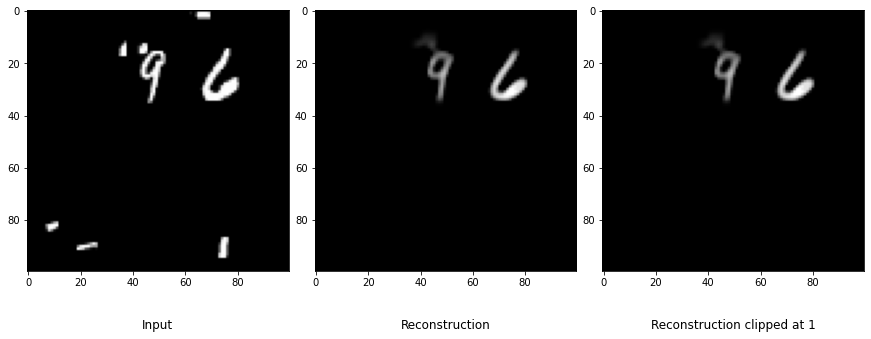

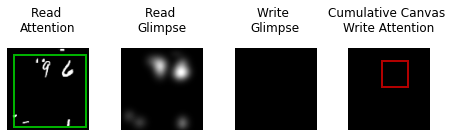

tensor([4.7917e-03, 2.4128e-02, 1.9605e-02, 1.8785e-02, 7.4501e-04, 1.7137e-01,
        2.0214e-03, 1.0525e-02, 2.5194e-02, 7.9173e-02, 4.9338e-06])
tensor([ 5,  9,  8,  1,  2,  3,  7,  0,  6,  4, 10])


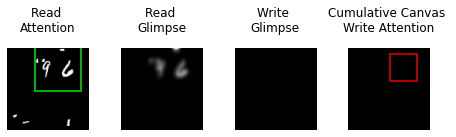

tensor([5.9906e-02, 6.3574e-02, 5.6439e-02, 2.6212e-02, 9.0810e-02, 2.2747e-03,
        8.4564e-02, 6.1698e-02, 4.2068e-03, 2.2635e-03, 2.9052e-05])
tensor([ 4,  6,  1,  7,  0,  2,  3,  8,  5,  9, 10])


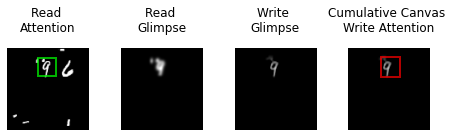

tensor([4.1271e-03, 1.2288e-03, 7.8771e-03, 4.4146e-03, 4.7325e-03, 2.8612e-03,
        4.7789e-03, 1.0823e-02, 6.5266e-03, 7.4906e-01, 1.1086e-04])
tensor([ 9,  7,  2,  8,  6,  4,  3,  0,  5,  1, 10])


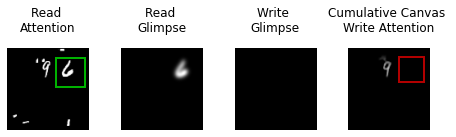

tensor([1.1440e-03, 2.1286e-04, 8.3643e-03, 1.1825e-02, 4.5533e-04, 1.2332e-03,
        2.4857e-01, 6.9220e-03, 1.3595e-02, 2.0260e-03, 2.8261e-05])
tensor([ 6,  8,  3,  2,  7,  9,  5,  0,  4,  1, 10])


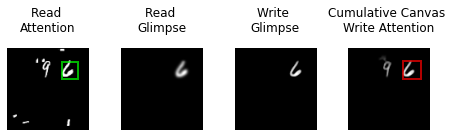

tensor([2.2599e-03, 2.1291e-03, 1.0329e-02, 7.0806e-03, 3.5499e-03, 2.4302e-03,
        8.7096e-01, 3.6094e-03, 1.1444e-02, 2.5600e-03, 2.4573e-04])
tensor([ 6,  8,  2,  3,  7,  4,  9,  5,  0,  1, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.2229e-02, 9.1273e-02, 1.0261e-01, 6.8317e-02, 1.0029e-01, 1.8017e-01,
        1.2109e+00, 9.3577e-02, 6.0966e-02, 8.3508e-01, 4.1884e-04],
       device='cuda:0')
tensor([ 6,  9,  5,  2,  4,  7,  1,  0,  3,  8, 10], device='cuda:0')

****************************************************************************************************
trial 28

ground truth
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
tensor([3, 5])
model prediction
tensor([0.0713, 0.0899, 0.1052, 1.0495, 0.1013, 1.2013, 0.1374, 0.0875, 0.0959,
        0.0911])
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
tensor([3, 5])
partial score, 1.0, exact score, True


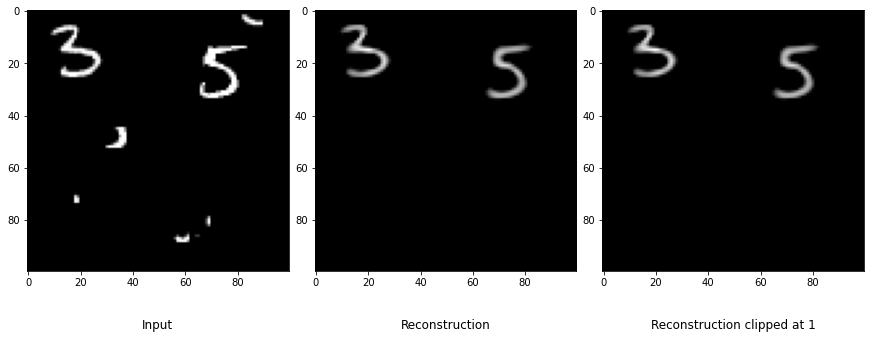

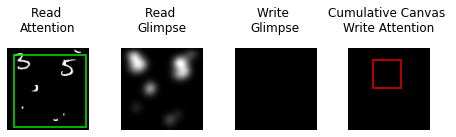

tensor([9.2831e-03, 2.3598e-02, 2.3290e-02, 1.3455e-02, 1.4342e-03, 1.4584e-01,
        4.9244e-03, 1.3750e-02, 3.1746e-02, 7.9363e-02, 5.7654e-06])
tensor([ 5,  9,  8,  1,  2,  7,  3,  0,  6,  4, 10])


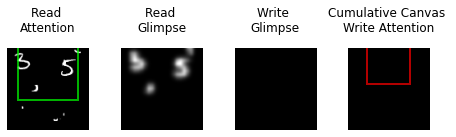

tensor([4.9636e-02, 5.2395e-02, 3.9769e-02, 7.3234e-02, 8.6249e-02, 1.6418e-02,
        1.1365e-01, 5.6214e-02, 1.3735e-02, 2.8950e-03, 6.9070e-05])
tensor([ 6,  4,  3,  7,  1,  0,  2,  5,  8,  9, 10])


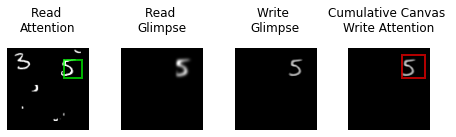

tensor([2.1071e-03, 3.9398e-03, 7.9146e-03, 7.4990e-03, 7.7530e-03, 8.4646e-01,
        4.8045e-03, 3.7132e-03, 2.4222e-02, 2.2958e-03, 1.2031e-04])
tensor([ 5,  8,  2,  4,  3,  6,  1,  7,  9,  0, 10])


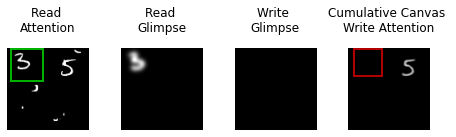

tensor([2.6435e-03, 5.4288e-03, 1.2447e-02, 8.9606e-02, 3.5409e-03, 1.8841e-01,
        6.0601e-03, 7.8733e-03, 2.7314e-03, 1.4473e-03, 1.8792e-05])
tensor([ 5,  3,  2,  7,  6,  1,  4,  8,  0,  9, 10])


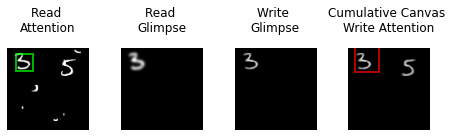

tensor([7.5995e-03, 4.5260e-03, 2.1779e-02, 8.6573e-01, 2.2827e-03, 4.1826e-03,
        7.9120e-03, 5.9843e-03, 2.3433e-02, 5.0973e-03, 1.3241e-04])
tensor([ 3,  8,  2,  6,  0,  7,  9,  1,  5,  4, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.1269e-02, 8.9888e-02, 1.0520e-01, 1.0495e+00, 1.0126e-01, 1.2013e+00,
        1.3735e-01, 8.7535e-02, 9.5867e-02, 9.1099e-02, 3.4635e-04],
       device='cuda:0')
tensor([ 5,  3,  6,  2,  4,  8,  9,  1,  7,  0, 10], device='cuda:0')

****************************************************************************************************
trial 29

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
model prediction
tensor([0.0441, 1.1881, 0.0478, 0.0573, 0.0177, 0.0633, 0.0259, 0.0422, 0.0248,
        1.1069])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
partial score, 1.0, exact score, True


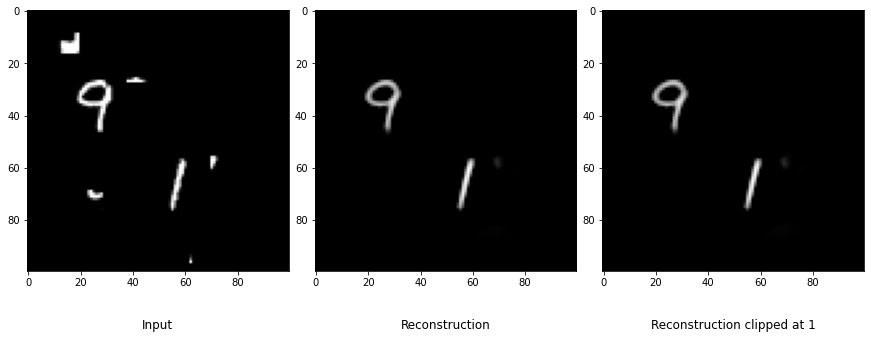

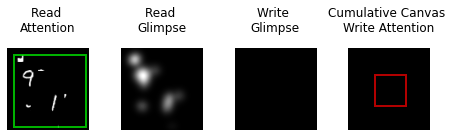

tensor([5.2706e-04, 2.0076e-03, 3.2138e-03, 2.0757e-02, 1.5326e-03, 5.1743e-02,
        3.0373e-03, 4.4897e-03, 7.5133e-03, 1.1094e-01, 6.6833e-06])
tensor([ 9,  5,  3,  8,  7,  2,  6,  1,  4,  0, 10])


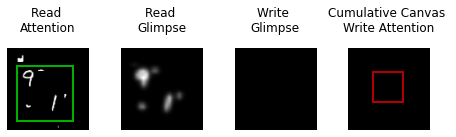

tensor([3.3128e-02, 2.9256e-01, 2.7569e-02, 1.8314e-02, 9.4979e-03, 4.3001e-03,
        1.7133e-02, 2.3659e-02, 5.3110e-03, 4.1297e-03, 4.0938e-05])
tensor([ 1,  0,  2,  7,  3,  6,  4,  8,  5,  9, 10])


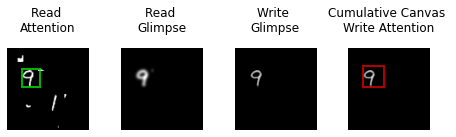

tensor([6.0753e-03, 2.7854e-03, 4.2292e-03, 5.1690e-03, 3.3415e-03, 2.9410e-03,
        1.1672e-03, 6.7963e-03, 4.0504e-03, 8.4576e-01, 2.2613e-04])
tensor([ 9,  7,  0,  3,  2,  8,  4,  5,  1,  6, 10])


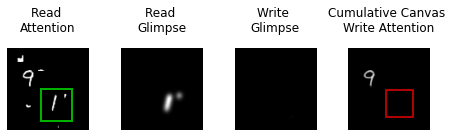

tensor([2.9597e-03, 8.1639e-02, 2.4712e-03, 3.0525e-03, 8.3005e-04, 2.2387e-03,
        7.4748e-04, 4.4772e-03, 3.8762e-03, 1.4541e-01, 2.3595e-05])
tensor([ 9,  1,  7,  8,  3,  0,  2,  5,  4,  6, 10])


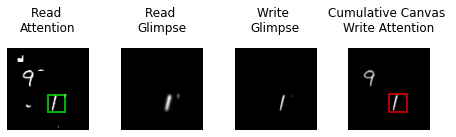

tensor([1.4303e-03, 8.0912e-01, 1.0333e-02, 1.0047e-02, 2.4683e-03, 2.0278e-03,
        3.8470e-03, 2.7318e-03, 4.0623e-03, 6.4776e-04, 9.0429e-05])
tensor([ 1,  2,  3,  8,  6,  7,  4,  5,  0,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([4.4120e-02, 1.1881e+00, 4.7817e-02, 5.7340e-02, 1.7670e-02, 6.3251e-02,
        2.5932e-02, 4.2154e-02, 2.4813e-02, 1.1069e+00, 3.8778e-04],
       device='cuda:0')
tensor([ 1,  9,  5,  3,  2,  0,  7,  6,  8,  4, 10], device='cuda:0')

****************************************************************************************************
trial 30

ground truth
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([5, 7])
model prediction
tensor([0.1008, 0.0982, 0.1059, 0.0389, 0.0888, 1.1500, 0.1352, 0.9410, 0.0412,
        0.0795])
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([5, 7])
partial score, 1.0, exact score, True


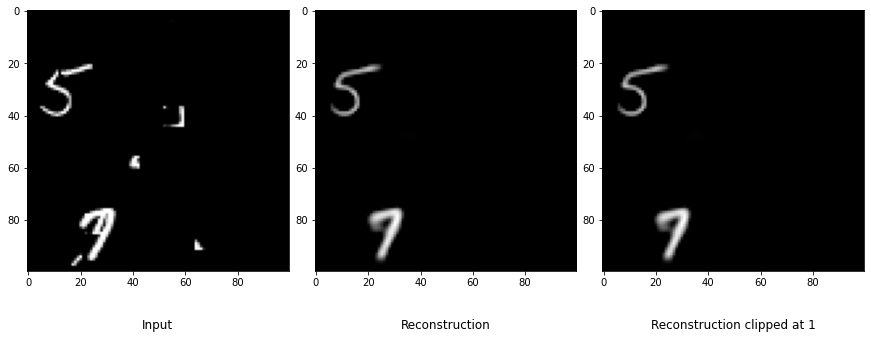

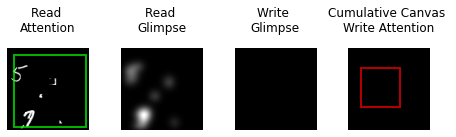

tensor([1.6343e-02, 4.6114e-03, 9.2221e-03, 1.5649e-02, 3.9297e-03, 1.2179e-01,
        1.1114e-02, 4.5203e-03, 1.4429e-02, 6.2025e-02, 9.3429e-06])
tensor([ 5,  9,  0,  3,  8,  6,  2,  1,  7,  4, 10])


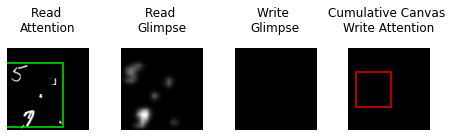

tensor([7.9301e-02, 8.9909e-02, 7.3249e-02, 4.7911e-03, 7.9772e-02, 2.6532e-03,
        1.1565e-01, 9.1210e-02, 9.1166e-03, 1.2093e-02, 3.5444e-05])
tensor([ 6,  7,  1,  4,  0,  2,  9,  8,  3,  5, 10])


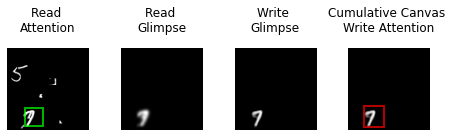

tensor([1.5768e-03, 1.0871e-03, 1.8121e-02, 1.1178e-02, 1.7308e-03, 1.9545e-03,
        2.1710e-03, 7.9451e-01, 3.7529e-03, 3.8953e-03, 5.7072e-05])
tensor([ 7,  2,  3,  9,  8,  6,  5,  4,  0,  1, 10])


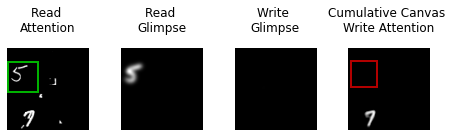

tensor([2.1161e-03, 1.3959e-03, 3.4053e-03, 1.8463e-03, 7.4311e-04, 1.4965e-01,
        1.4689e-03, 4.1482e-02, 7.7902e-03, 6.1897e-04, 1.7872e-05])
tensor([ 5,  7,  8,  2,  0,  3,  6,  1,  4,  9, 10])


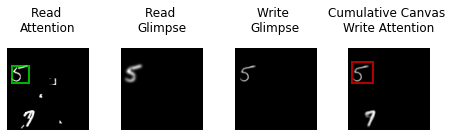

tensor([1.4940e-03, 1.1826e-03, 1.9434e-03, 5.4458e-03, 2.6395e-03, 8.7397e-01,
        4.7634e-03, 9.2398e-03, 6.1431e-03, 8.8837e-04, 1.9375e-04])
tensor([ 5,  7,  8,  3,  6,  4,  2,  0,  1,  9, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0083e-01, 9.8186e-02, 1.0594e-01, 3.8910e-02, 8.8816e-02, 1.1500e+00,
        1.3517e-01, 9.4096e-01, 4.1232e-02, 7.9521e-02, 3.1348e-04],
       device='cuda:0')
tensor([ 5,  7,  6,  2,  0,  1,  4,  9,  8,  3, 10], device='cuda:0')

****************************************************************************************************
trial 31

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])
tensor([3, 7])
model prediction
tensor([0.0758, 0.0782, 0.0893, 1.0357, 0.0940, 0.1472, 0.1359, 1.1488, 0.0661,
        0.0806])
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])
tensor([3, 7])
partial score, 1.0, exact score, True


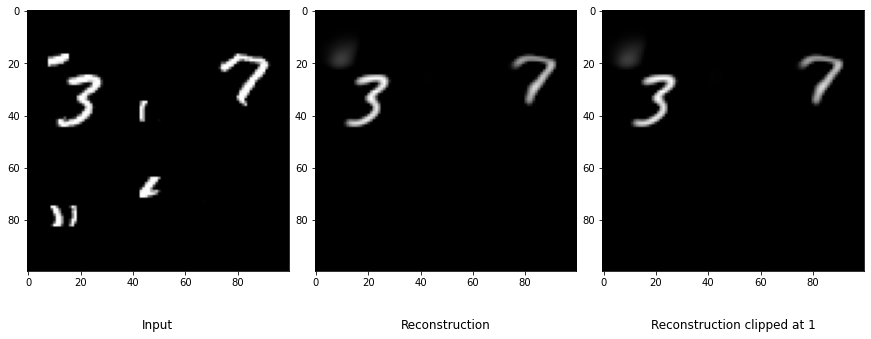

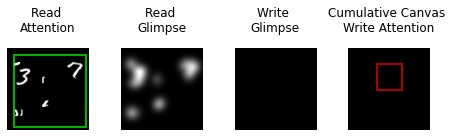

tensor([1.5772e-02, 1.4464e-02, 2.7394e-02, 1.7547e-02, 2.9354e-03, 1.1736e-01,
        5.9926e-03, 2.7025e-02, 3.3855e-02, 7.2374e-02, 3.4835e-06])
tensor([ 5,  9,  8,  2,  7,  3,  0,  1,  6,  4, 10])


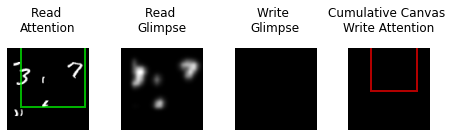

tensor([5.4906e-02, 5.6789e-02, 3.9357e-02, 1.0122e-01, 8.6866e-02, 2.5857e-02,
        1.1594e-01, 5.5168e-02, 9.8645e-03, 4.3699e-03, 5.7449e-05])
tensor([ 6,  3,  4,  1,  7,  0,  2,  5,  8,  9, 10])


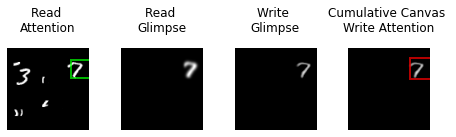

tensor([2.5774e-03, 4.0476e-03, 6.6074e-03, 1.9988e-03, 1.4528e-03, 1.6346e-03,
        2.7753e-03, 7.7602e-01, 5.1873e-03, 2.1237e-03, 4.2684e-05])
tensor([ 7,  2,  8,  1,  6,  0,  9,  3,  5,  4, 10])


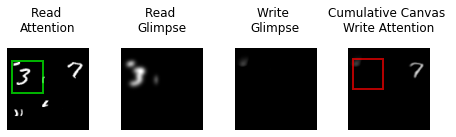

tensor([1.8630e-03, 2.4055e-03, 9.5991e-03, 2.3816e-02, 1.9299e-03, 1.9822e-03,
        3.4306e-03, 2.8153e-01, 6.7461e-03, 9.6398e-04, 1.4224e-05])
tensor([ 7,  3,  2,  8,  6,  1,  5,  4,  0,  9, 10])


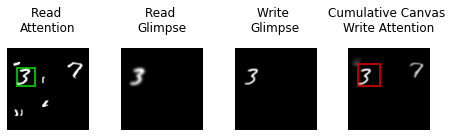

tensor([6.7576e-04, 5.0346e-04, 6.3094e-03, 8.9114e-01, 8.0378e-04, 3.1896e-04,
        7.7449e-03, 9.1053e-03, 1.0437e-02, 7.8395e-04, 2.2698e-04])
tensor([ 3,  8,  7,  6,  2,  4,  9,  0,  1,  5, 10])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([7.5794e-02, 7.8209e-02, 8.9266e-02, 1.0357e+00, 9.3988e-02, 1.4715e-01,
        1.3588e-01, 1.1488e+00, 6.6089e-02, 8.0616e-02, 3.4482e-04],
       device='cuda:0')
tensor([ 7,  3,  5,  6,  4,  2,  9,  1,  0,  8, 10], device='cuda:0')


In [8]:
import matplotlib.gridspec as gridspec

num_trials = 32
idtrial_incorrect = []
save_plot = 1
create_gif = 1
fig_folder = args.output_dir + 'cluttered_5/'  # folder to save figs/gifs

if args.use_read_attn == False:
    args.read_size = args.image_dims[1]

if args.use_write_attn == False:
    args.write_size = args.image_dims[1]

y_pred_nars = y_pred.narrow(1,0,args.num_classes) 
y_pred_hots, _ , paccs , _, eaccs = cal_accs(y_pred_nars, y.to(args.device), readout_logits, args)

for i in range(num_trials): #len(y)):

    y_true = y[i].cpu()

    if torch.max(y_true) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_os = torch.squeeze(torch.nonzero(torch.squeeze(y_true)))
    else:
        y_os = torch.cat( (torch.nonzero(torch.squeeze(y_true))[0], torch.nonzero(torch.squeeze(y_true))[0]))

    y_pred_hot = y_pred_hots[i].cpu()
    y_pred_nar = y_pred_nars[i].cpu()
    if torch.max(y_pred_hot) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_pred_os = torch.squeeze(torch.nonzero(torch.squeeze(y_pred_hot)))
    else:
        y_pred_os = torch.cat( (torch.nonzero(torch.squeeze(y_pred_hot))[0], torch.nonzero(torch.squeeze(y_pred_hot))[0]))

    correct_partial = paccs[i].cpu()
    correct_exact = eaccs[i].cpu()

    # print only incorrect trials 
#     if correct_exact == 1:
#         continue 
#     idtrial_incorrect.append(i)
        
    print('\n' + '*'*100)
    print('trial ' + str(i))
        
    print('\nground truth')
    print(y_true)
    print(y_os)
    
    print('model prediction')
    print(y_pred_nar)
    print(y_pred_hot)
    print(y_pred_os)
        
    print(f'partial score, {correct_partial}, exact score, {correct_exact}')
    
        
    g_h = 1
    g_w = 3
    fig = plt.figure(figsize=(15,6))
    gs1 = gridspec.GridSpec(g_h, g_w)
    gs1.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    ax = plt.subplot(gs1[0,0])
    ax.imshow(torch.squeeze(x[i].movedim(0,-1)), cmap='gray')
    ax.text(0.5,-0.22,  "Input", size=12, ha="center", transform=ax.transAxes)

    ax = plt.subplot(gs1[0,1])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction", size=12, ha="center", transform=ax.transAxes)
    
    ax = plt.subplot(gs1[0,2])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), vmin=0, vmax=1, cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction clipped at 1", size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

    #--------------------------------------
    # plotting read and  write operatoins 
    
    
    for j in range(args.time_steps):
        
        g_h = 1
        g_w = 5
        fig = plt.figure(figsize=(10,1.5))
        gs1 = gridspec.GridSpec(g_h, g_w)
        gs1.update(wspace=0.1, hspace=0.1)

        class_l = torch.zeros((args.time_steps, args.num_classes+args.backg_objcaps))
    
        ax = plt.subplot(gs1[0,0])
        
#         if args.task == 'MultiMNIST_tracking':
#             print(x[i].shape)
#             x_t = x[i].narrow(0,j,1)
            
#         else:
        x_t = x[i]

        ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        
        ax.text(0.5,1.2,  "Read \nAttention", \
        size=12, ha="center", transform=ax.transAxes)
        
        #if args.use_glimpse_attn:
        if args.use_read_attn:
            mu_x = read_mu_xs[j][i]
            mu_y = read_mu_ys[j][i]

            r_x = mu_x[0]
            r_y = mu_y[0]
            r_w = mu_y[-1] - mu_y[0]
            r_h = mu_x[-1] - mu_x[0]

            ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))
            #-------------------------------------

#         if args.use_soft_attn:
#             p = j*step_num 
#             soft_map = att_param[p][7][i].cpu().numpy()
            
#             soft_map = np.reshape(soft_map, (8, 8))
#             plt.imshow(soft_map)
#             plt.show()
#             print(len(soft_map))
#             print(soft_map[0].shape)
#             break

            
        ax = plt.subplot(gs1[0,1])
        ax.imshow(read_x_step[i][j].movedim(0,-1).cpu(), cmap='gray')
        ax.axis('off')
        #if j==0:
        ax.text(0.5,1.2,  "Read \nGlimpse", \
        size=12, ha="center", transform=ax.transAxes)
            
        
        #---------------------------------------
        if args.recon_model:
            #im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), (args.image_dims[1],args.image_dims[2]))
            im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), \
                                (args.image_dims[0], args.image_dims[1],args.image_dims[2])).transpose(1,2,0)

            ax = plt.subplot(gs1[0,3])
            ax.imshow(im, vmin=0, vmax=1 , cmap='gray')  # max(np.max(im),1)
            ax.axis('off')

            #if j==0:
            ax.text(0.5,1.2,  "Cumulative Canvas \nWrite Attention", \
            size=12, ha="center", transform=ax.transAxes)
            
            if args.use_write_attn:
                mu_x = write_mu_xs[j][i]
                mu_y = write_mu_ys[j][i]

                w_x = mu_x[0]
                w_y = mu_y[0]
                w_w = mu_y[-1] - mu_y[0]
                w_h = mu_x[-1] - mu_x[0]

                ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))
                
                c_each = torch.clip(c_each, min=0, max=1)

                ax = plt.subplot(gs1[0,2])
                ax.imshow(c_each[i][j].movedim(0,-1).cpu(), vmin=0, vmax=1, cmap='gray')
                ax.axis('off')
                #if j==0:
                ax.text(0.5,1.2,  "Write \nGlimpse", \
                size=12, ha="center", transform=ax.transAxes)
        
#                 if args.task == 'MultiMNIST_tracking':
#                     x_t = x[i].narrow(0,j+1,1)
#                     ax = plt.subplot(gs1[j,5])
#                     ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
                        


        if save_plot:
            
            plt.margins(0,0)    
            save_folder = fig_folder + str(i) + '/'
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            fig.savefig( save_folder + 'image{:02d}'.format(j) + '.png', bbox_inches='tight', pad_inches=0.0)

        plt.show()
        
        class_l[j,:] = objcaps_len_step[i][j]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)

        print(class_l[j,:])  # .cpu().numpy()
        print(indices)   # .cpu().numpy()
        #print('_ ' * 40 + '\n')
    
    print('_ ' * 40 + '\n')
    class_l_sum = torch.sum(objcaps_len_step[i],dim=0)
    print(class_l_sum)
    class_sorted_sum, indices_sum = torch.sort(class_l_sum, dim=0, descending=True)
    print(indices_sum)
        
    if save_plot:    
        if create_gif:  

            import imageio
            from PIL import Image
            import glob
            image_list = []
            for filename in glob.glob(save_folder+ '/*.png'): #assuming gif
                im=Image.open(filename)
                image_list.append(np.array(im))


            file_add = (os.path.join(save_folder, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
            imageio.mimsave(file_add, image_list, duration=0.4)


            #print("The accuracy for this batch is: " + str(test_acc) )

            IP_Image(open(file_add,'rb').read(), width = 600, height = 600)
    
    
    